In [15]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# snnTorch imports
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import utils
import snntorch.spikegen as spikegen

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 데이터 경로 설정
DATA_PATH = "../../data/DB6/DB6_s1_a/S1_D1_T1.mat"

# ======================
# Dataset Class
# ======================

class EMGDataset(Dataset):
    """EMG 데이터셋 클래스"""
    def __init__(self, X, y, transform=None):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
        self.transform = transform
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        sample = self.X[idx]
        label = self.y[idx]
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample, label

# ======================
# TCN Components
# ======================

class TemporalBlock(nn.Module):
    """TCN의 기본 빌딩 블록"""
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        
        self.conv1 = nn.Conv1d(n_inputs, n_outputs, kernel_size,
                              stride=stride, padding=padding, dilation=dilation)
        self.bn1 = nn.BatchNorm1d(n_outputs)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        
        self.conv2 = nn.Conv1d(n_outputs, n_outputs, kernel_size,
                              stride=stride, padding=padding, dilation=dilation)
        self.bn2 = nn.BatchNorm1d(n_outputs)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        
        # Residual connection
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        
    def forward(self, x):
        residual = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.dropout1(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        
        if self.downsample is not None:
            residual = self.downsample(x)

        if out.shape != residual.shape:
            min_len = min(out.shape[2], residual.shape[2])
            out = out[:, :, :min_len]
            residual = residual[:, :, :min_len] 
            
        out += residual
        return self.relu(out)

class TemporalConvNet(nn.Module):
    """Temporal Convolutional Network"""
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            
            # Causal padding
            padding = (kernel_size - 1) * dilation_size
            
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, 
                                   stride=1, dilation=dilation_size, 
                                   padding=padding, dropout=dropout)]
        
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        # x shape: (batch_size, seq_len, features) -> (batch_size, features, seq_len)
        x = x.transpose(1, 2)
        out = self.network(x)
        # Back to (batch_size, seq_len, features)
        return out.transpose(1, 2)

# ======================
# SNN Components using snnTorch
# ======================

class SpikeEncoder(nn.Module):
    """연속 신호를 스파이크로 변환하는 인코더"""
    def __init__(self, encoding_type='rate', num_steps=200):
        super(SpikeEncoder, self).__init__()
        self.encoding_type = encoding_type
        self.num_steps = num_steps
        
    def forward(self, x):
        # x shape: (batch_size, seq_len, features)
        batch_size, seq_len, features = x.shape
        
        if self.encoding_type == 'rate':
            # Rate encoding: 입력 크기에 비례하는 스파이크 확률
            # 입력을 0-1 범위로 정규화
            x_norm = torch.sigmoid(x)
            # Poisson spike generation
            spikes = spikegen.rate(x_norm, num_steps=seq_len)
            return spikes
        
        elif self.encoding_type == 'latency':
            # Latency encoding
            spikes = spikegen.latency(x, num_steps=seq_len, normalize=True, linear=True)
            return spikes
        
        else:  # 'delta'
            # Delta modulation
            spikes = spikegen.delta(x, threshold=0.1)
            return spikes

class SNNBlock(nn.Module):
    """SNN 블록 (LIF 뉴런 사용)"""
    def __init__(self, input_size, hidden_size, num_steps=200, beta=0.9, threshold=1.0):
        super(SNNBlock, self).__init__()
        
        self.num_steps = num_steps
        self.hidden_size = hidden_size
        
        # Linear layer
        self.fc = nn.Linear(input_size, hidden_size)
        
        # LIF neuron
        self.lif = snn.Leaky(beta=beta, threshold=threshold, 
                            spike_grad=surrogate.fast_sigmoid())
        
    def forward(self, x):
        # x shape: (num_steps, batch_size, input_size)
        batch_size = x.shape[1]
        
        # Initialize hidden states
        mem = self.lif.init_leaky()
        
        spk_rec = []
        mem_rec = []
        
        for step in range(self.num_steps):
            cur = self.fc(x[step])
            spk, mem = self.lif(cur, mem)
            spk_rec.append(spk)
            mem_rec.append(mem)
            
        return torch.stack(spk_rec, dim=0), torch.stack(mem_rec, dim=0)

class SpikingNeuralNetwork(nn.Module):
    """Multi-layer SNN"""
    def __init__(self, input_size, hidden_sizes, num_steps=200, beta=0.9, threshold=1.0):
        super(SpikingNeuralNetwork, self).__init__()
        
        self.num_steps = num_steps
        self.layers = nn.ModuleList()
        
        # Input encoding
        self.encoder = SpikeEncoder(encoding_type='rate', num_steps=num_steps)
        
        # SNN layers
        layer_sizes = [input_size] + hidden_sizes
        for i in range(len(hidden_sizes)):
            self.layers.append(
                SNNBlock(layer_sizes[i], layer_sizes[i+1], 
                        num_steps=num_steps, beta=beta, threshold=threshold)
            )
    
    def forward(self, x):
        # Encode input to spikes
        spikes = self.encoder(x)  # (num_steps, batch_size, features)
        
        # Pass through SNN layers
        for layer in self.layers:
            spikes, _ = layer(spikes)
            
        return spikes

# ======================
# Model Architectures
# ======================

class TCNClassifier(nn.Module):
    """TCN 기반 EMG 분류기"""
    def __init__(self, input_size, num_classes, tcn_channels=[64, 128, 256], 
                 kernel_size=3, dropout=0.2):
        super(TCNClassifier, self).__init__()
        
        self.tcn = TemporalConvNet(input_size, tcn_channels, kernel_size, dropout)
        
        # Attention mechanism
        self.attention = nn.MultiheadAttention(tcn_channels[-1], num_heads=8, batch_first=True)
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(tcn_channels[-1], 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout/2),
            nn.Linear(64, num_classes)
        )
        
    def forward(self, x):
        # TCN feature extraction
        tcn_out = self.tcn(x)  # (batch_size, seq_len, features)
        
        # Self-attention
        attn_out, _ = self.attention(tcn_out, tcn_out, tcn_out)
        
        # Global average pooling
        pooled = torch.mean(attn_out, dim=1)  # (batch_size, features)
        
        # Classification
        output = self.classifier(pooled)
        return output

class SNNClassifier(nn.Module):
    """SNN 기반 EMG 분류기"""
    def __init__(self, input_size, num_classes, hidden_sizes=[128, 64], 
                 num_steps=200, beta=0.9, threshold=1.0):
        super(SNNClassifier, self).__init__()
        
        self.num_steps = num_steps
        self.snn = SpikingNeuralNetwork(input_size, hidden_sizes, 
                                       num_steps, beta, threshold)
        
        # Output layer
        self.output_layer = nn.Linear(hidden_sizes[-1], num_classes)
        
    def forward(self, x):
        batch_size, seq_len, features = x.shape
        
        # Get spike outputs from SNN
        spikes = self.snn(x)  # (num_steps, batch_size, hidden_size)
        
        # Convert spikes to rates (average over time)
        spike_rates = torch.mean(spikes, dim=0)  # (batch_size, hidden_size)
        
        # Classification
        output = self.output_layer(spike_rates)
        output = torch.mean(output, dim=1)
        return output

class HybridTCNSNN(nn.Module):
    """TCN과 SNN을 결합한 하이브리드 모델"""
    def __init__(self, input_size, num_classes, tcn_channels=[32, 64], 
                 snn_hidden_sizes=[64, 32], num_steps=200, kernel_size=3, dropout=0.2):
        super(HybridTCNSNN, self).__init__()
        
        self.num_steps = num_steps
        
        # TCN branch
        self.tcn = TemporalConvNet(input_size, tcn_channels, kernel_size, dropout)
        
        # SNN branch
        self.snn = SpikingNeuralNetwork(input_size, snn_hidden_sizes, num_steps)
        
        # Feature fusion
        combined_size = tcn_channels[-1] + snn_hidden_sizes[-1]
        self.fusion = nn.Sequential(
            nn.Linear(combined_size, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout/2),
            nn.Linear(64, num_classes)
        )
        
    def forward(self, x):
        # TCN branch
        tcn_out = self.tcn(x)
        tcn_pooled = torch.mean(tcn_out, dim=1)  # Global average pooling
        
        # SNN branch
        snn_spikes = self.snn(x)
        snn_rates = torch.mean(snn_spikes, dim=0)  # Convert to rates

        snn_rates = torch.mean(snn_rates, dim=1)
        
        # Combine features
        combined = torch.cat([tcn_pooled, snn_rates], dim=1)
        
        # Final classification
        output = self.fusion(combined)
        return output

# ======================
# Data Loading Functions
# ======================

def load_ninapro_data(file_path):
    """NinaPro 데이터를 로드하고 전처리하는 함수"""
    try:
        # .mat 파일 로드
        data = sio.loadmat(file_path)
        
        print("Available keys in the data:", list(data.keys()))
        
        # EMG 데이터 추출
        if 'emg' in data:
            emg_data = data['emg']
        elif 'data' in data:
            emg_data = data['data']
        else:
            data_keys = [k for k in data.keys() if not k.startswith('__')]
            emg_data = data[data_keys[0]]
        
        # 라벨 데이터 추출
        if 'stimulus' in data:
            labels = data['stimulus'].flatten()
        elif 'restimulus' in data:
            labels = data['restimulus'].flatten()
        elif 'glove' in data:
            labels = data['glove']
            if labels.ndim > 1:
                labels = labels[:, 0]
        else:
            label_keys = [k for k in data.keys() if 'stimulus' in k.lower() or 'label' in k.lower()]
            if label_keys:
                labels = data[label_keys[0]].flatten()
            else:
                data_keys = [k for k in data.keys() if not k.startswith('__')]
                labels = data[data_keys[1]].flatten() if len(data_keys) > 1 else np.zeros(emg_data.shape[0])
        
        print(f"EMG data shape: {emg_data.shape}")
        print(f"Labels shape: {labels.shape}")
        print(f"Unique labels: {np.unique(labels)}")
        
        return emg_data, labels
    
    except Exception as e:
        print(f"Error loading data: {e}")
        print("Generating sample data for demonstration...")
        
        # 샘플 데이터 생성
        n_samples = 10000
        n_channels = 12
        emg_data = np.random.randn(n_samples, n_channels) * 0.1
        
        # EMG 신호처럼 보이도록 시간적 상관관계 추가
        for i in range(n_channels):
            emg_data[:, i] += np.sin(np.linspace(0, 100*np.pi, n_samples) + i) * 0.05
            emg_data[:, i] += np.convolve(np.random.randn(n_samples), 
                                        np.ones(5)/5, mode='same') * 0.02
        
        labels = np.random.randint(0, 7, n_samples)  # 0-6 클래스
        return emg_data, labels

def preprocess_data_for_networks(emg_data, labels, window_size=200, overlap=100):
    """네트워크를 위한 EMG 데이터 전처리"""
    # 레이블이 0인 rest 구간 제거 (선택사항)
    non_zero_mask = labels != 0
    emg_data = emg_data[non_zero_mask]
    labels = labels[non_zero_mask]
    
    # 윈도우 기반 시퀀스 생성
    windowed_sequences = []
    windowed_labels = []
    
    step_size = window_size - overlap
    
    for i in range(0, len(emg_data) - window_size + 1, step_size):
        window = emg_data[i:i+window_size]
        window_label = labels[i:i+window_size]
        
        # 윈도우 내에서 가장 빈번한 라벨 사용
        unique_labels, counts = np.unique(window_label, return_counts=True)
        dominant_label = unique_labels[np.argmax(counts)]
        
        windowed_sequences.append(window)
        windowed_labels.append(dominant_label)
    
    return np.array(windowed_sequences), np.array(windowed_labels)

# ======================
# Training Functions
# ======================

def train_model(model, train_loader, val_loader, num_epochs=100, lr=0.001):
    """모델 훈련 함수"""
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, verbose=True)
    
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    best_val_acc = 0.0
    patience_counter = 0
    patience = 20
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()
        
        train_acc = 100 * train_correct / train_total
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_acc)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                
                val_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()
        
        val_acc = 100 * val_correct / val_total
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_acc)
        
        # Learning rate scheduling
        scheduler.step(val_acc)
        
        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc:.2f}%, '
                  f'Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc:.2f}%')
    
    # Load best model
    model.load_state_dict(torch.load('best_model.pth'))
    
    history = {
        'train_loss': train_losses,
        'train_acc': train_accuracies,
        'val_loss': val_losses,
        'val_acc': val_accuracies
    }
    
    return model, history

def evaluate_model(model, test_loader):
    """모델 평가 함수"""
    model.eval()
    test_correct = 0
    test_total = 0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            
            test_total += target.size(0)
            test_correct += (predicted == target).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    test_acc = 100 * test_correct / test_total
    return test_acc, np.array(all_predictions), np.array(all_targets)

# ======================
# Visualization Functions
# ======================

def plot_training_history(histories, model_names):
    """훈련 과정 시각화"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    colors = ['blue', 'red', 'green', 'orange', 'purple']
    
    for i, (history, name) in enumerate(zip(histories, model_names)):
        color = colors[i % len(colors)]
        
        # Training accuracy
        axes[0, 0].plot(history['train_acc'], label=f'{name}', 
                       color=color, linewidth=2)
        
        # Validation accuracy
        axes[0, 1].plot(history['val_acc'], label=f'{name}', 
                       color=color, linewidth=2)
        
        # Training loss
        axes[1, 0].plot(history['train_loss'], label=f'{name}', 
                       color=color, linewidth=2)
        
        # Validation loss
        axes[1, 1].plot(history['val_loss'], label=f'{name}', 
                       color=color, linewidth=2)
    
    axes[0, 0].set_title('Training Accuracy', fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy (%)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].set_title('Validation Accuracy', fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    axes[1, 0].set_title('Training Loss', fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    axes[1, 1].set_title('Validation Loss', fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle('Model Training Comparison', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names, model_name):
    """혼동 행렬 시각화"""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} - Confusion Matrix', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

def visualize_snn_spikes(model, sample_data, num_steps=200, num_neurons=10):
    """SNN 스파이크 시각화"""
    if not hasattr(model, 'snn'):
        print("Model doesn't have SNN component")
        return
    
    model.eval()
    with torch.no_grad():
        sample_data = sample_data.to(device)
        
        # Get spikes from SNN
        if hasattr(model, 'snn'):
            spikes = model.snn(sample_data[:1])  # First sample only
        else:
            # For pure SNN model
            spikes = model.snn(sample_data[:1])
        
        # spikes shape: (num_steps, 1, hidden_size)
        spike_data = spikes.squeeze(1).cpu().numpy()  # (num_steps, hidden_size)
        
        plt.figure(figsize=(15, 8))
        
        # Raster plot
        for neuron_idx in range(min(num_neurons, spike_data.shape[1])):
            spike_times = np.where(spike_data[:, neuron_idx] > 0.5)[0]
            plt.scatter(spike_times, [neuron_idx] * len(spike_times), 
                       marker='|', s=50, alpha=0.7)
        
        plt.xlabel('Time Steps')
        plt.ylabel('Neuron Index')
        plt.title('SNN Spike Raster Plot')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Firing rate histogram
        firing_rates = np.mean(spike_data, axis=0)
        plt.figure(figsize=(12, 5))
        plt.bar(range(len(firing_rates)), firing_rates, alpha=0.7)
        plt.xlabel('Neuron Index')
        plt.ylabel('Firing Rate')
        plt.title('Neuron Firing Rates')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

def plot_model_comparison_results(results):
    """모델 성능 비교 결과 시각화"""
    model_names = list(results.keys())
    accuracies = [results[name]['test_acc'] for name in model_names]
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(model_names, accuracies, alpha=0.7, 
                   color=['blue', 'red', 'green', 'orange'])
    
    # Add value labels on bars
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{acc:.2f}%', ha='center', va='bottom', fontweight='bold')
    
    plt.ylabel('Test Accuracy (%)')
    plt.title('Model Performance Comparison', fontsize=16, fontweight='bold')
    plt.ylim(0, 100)
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

# ======================
# Main Function
# ======================



Using device: cpu


In [17]:
print("=== EMG Classification with TCN and SNN using PyTorch ===")
    
    # 1. 데이터 로드
print("\n1. Loading data...")
emg_data, labels = load_ninapro_data(DATA_PATH)
    
    # 2. 데이터 전처리
print("\n2. Preprocessing data...")
X, y = preprocess_data_for_networks(emg_data, labels, window_size=200, overlap=100)
    
print(f"Sequence data shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Number of classes: {len(np.unique(y))}")
    
    # 3. 라벨 인코딩
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(np.unique(y_encoded))
class_names = [f"Gesture {i}" for i in range(num_classes)]
    
    # 4. 데이터 분할
print("\n3. Splitting data...")
X_temp, X_test, y_temp, y_test = train_test_split(
        X, y_encoded, test_size=0.15, random_state=42, stratify=y_encoded
    )
    
X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp
    )
    
print(f"Train set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
    
    # 5. 데이터 정규화
print("\n4. Normalizing data...")
scaler = StandardScaler()

    # 2D로 변형 후 스케일링, 다시 3D로 복원
X_train_res = X_train.reshape(-1, X_train.shape[-1])
X_val_res = X_val.reshape(-1, X_val.shape[-1])
X_test_res = X_test.reshape(-1, X_test.shape[-1])

X_train_scaled = scaler.fit_transform(X_train_res).reshape(X_train.shape)
X_val_scaled = scaler.transform(X_val_res).reshape(X_val.shape)
X_test_scaled = scaler.transform(X_test_res).reshape(X_test.shape)

    # 6. DataLoader 생성
print("\n5. Creating DataLoaders...")
train_dataset = EMGDataset(X_train_scaled, y_train)
val_dataset = EMGDataset(X_val_scaled, y_val)
test_dataset = EMGDataset(X_test_scaled, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 7. 모델 학습 및 평가
print("\n6. Training Models...")
results = {}
histories = []

# SNN
print("\n--- Training SNN Model ---")
snn_model = SNNClassifier(input_size=X_train.shape[-1], num_classes=num_classes, num_steps=100)
snn_model, snn_history = train_model(snn_model, train_loader, val_loader)
snn_test_acc, snn_preds, snn_targets = evaluate_model(snn_model, test_loader)
results['SNN'] = {'test_acc': snn_test_acc, 'preds': snn_preds, 'targets': snn_targets}
histories.append(snn_history)


=== EMG Classification with TCN and SNN using PyTorch ===

1. Loading data...
Available keys in the data: ['__header__', '__version__', '__globals__', 'repetition', 'repetition_object', 'acc', 'daytesting', 'emg', 'object', 'reobject', 'rerepetition', 'restimulus', 'stimulus', 'subj', 'time']
EMG data shape: (1428729, 16)
Labels shape: (1428729,)
Unique labels: [ 0  1  3  4  6  9 10 11]

2. Preprocessing data...
Sequence data shape: (8176, 200, 16)
Labels shape: (8176,)
Number of classes: 7

3. Splitting data...
Train set: 5725 samples
Validation set: 1224 samples
Test set: 1227 samples

4. Normalizing data...

5. Creating DataLoaders...

6. Training Models...

--- Training SNN Model ---
Epoch [10/100], Train Loss: 1.6897, Train Acc: 36.98%, Val Loss: 1.6896, Val Acc: 34.40%
Epoch [20/100], Train Loss: 1.5718, Train Acc: 42.13%, Val Loss: 1.5613, Val Acc: 43.46%
Epoch [30/100], Train Loss: 1.5114, Train Acc: 43.28%, Val Loss: 1.5183, Val Acc: 46.08%
Epoch [40/100], Train Loss: 1.4749, 

In [18]:
# TCN
print("\n--- Training TCN Model ---")
tcn_model = TCNClassifier(input_size=X_train.shape[-1], num_classes=num_classes)
tcn_model, tcn_history = train_model(tcn_model, train_loader, val_loader)
tcn_test_acc, tcn_preds, tcn_targets = evaluate_model(tcn_model, test_loader)
results['TCN'] = {'test_acc': tcn_test_acc, 'preds': tcn_preds, 'targets': tcn_targets}
histories.append(tcn_history)


--- Training TCN Model ---
Epoch [10/100], Train Loss: 0.9852, Train Acc: 60.12%, Val Loss: 1.0143, Val Acc: 58.17%
Epoch [20/100], Train Loss: 0.7330, Train Acc: 71.44%, Val Loss: 0.9558, Val Acc: 64.95%
Epoch [30/100], Train Loss: 0.5024, Train Acc: 81.01%, Val Loss: 0.7822, Val Acc: 70.92%
Epoch [40/100], Train Loss: 0.3139, Train Acc: 89.05%, Val Loss: 1.1763, Val Acc: 66.58%
Epoch [50/100], Train Loss: 0.2151, Train Acc: 92.77%, Val Loss: 1.2232, Val Acc: 68.95%
Epoch [60/100], Train Loss: 0.0776, Train Acc: 97.50%, Val Loss: 1.1515, Val Acc: 73.77%
Epoch [70/100], Train Loss: 0.0604, Train Acc: 98.03%, Val Loss: 0.8257, Val Acc: 80.64%
Epoch [80/100], Train Loss: 0.0560, Train Acc: 98.10%, Val Loss: 0.8668, Val Acc: 80.07%
Epoch [90/100], Train Loss: 0.0215, Train Acc: 99.30%, Val Loss: 0.7925, Val Acc: 81.45%
Epoch [100/100], Train Loss: 0.0211, Train Acc: 99.34%, Val Loss: 0.7920, Val Acc: 83.82%


In [19]:
print("\n--- Training Hybrid TCN-SNN Model ---")
hybrid_model = HybridTCNSNN(input_size=X_train.shape[-1], num_classes=num_classes, num_steps=100)
hybrid_model, hybrid_history = train_model(hybrid_model, train_loader, val_loader)
hybrid_test_acc, hybrid_preds, hybrid_targets = evaluate_model(hybrid_model, test_loader)
results['Hybrid'] = {'test_acc': hybrid_test_acc, 'preds': hybrid_preds, 'targets': hybrid_targets}
histories.append(hybrid_history)


--- Training Hybrid TCN-SNN Model ---
Epoch [10/100], Train Loss: 0.9230, Train Acc: 64.70%, Val Loss: 0.8687, Val Acc: 67.40%
Epoch [20/100], Train Loss: 0.7418, Train Acc: 71.58%, Val Loss: 0.7496, Val Acc: 71.16%
Epoch [30/100], Train Loss: 0.6266, Train Acc: 76.00%, Val Loss: 0.6649, Val Acc: 74.02%
Epoch [40/100], Train Loss: 0.5407, Train Acc: 79.98%, Val Loss: 0.7257, Val Acc: 72.47%
Epoch [50/100], Train Loss: 0.4739, Train Acc: 82.48%, Val Loss: 0.6060, Val Acc: 76.14%
Epoch [60/100], Train Loss: 0.4204, Train Acc: 84.49%, Val Loss: 0.6239, Val Acc: 76.31%
Epoch [70/100], Train Loss: 0.3475, Train Acc: 87.55%, Val Loss: 0.6256, Val Acc: 75.16%
Epoch [80/100], Train Loss: 0.2891, Train Acc: 89.78%, Val Loss: 0.5657, Val Acc: 78.51%
Epoch [90/100], Train Loss: 0.2671, Train Acc: 90.46%, Val Loss: 0.5732, Val Acc: 78.27%
Epoch [100/100], Train Loss: 0.2514, Train Acc: 90.92%, Val Loss: 0.5614, Val Acc: 79.82%



7. Plotting Training History...


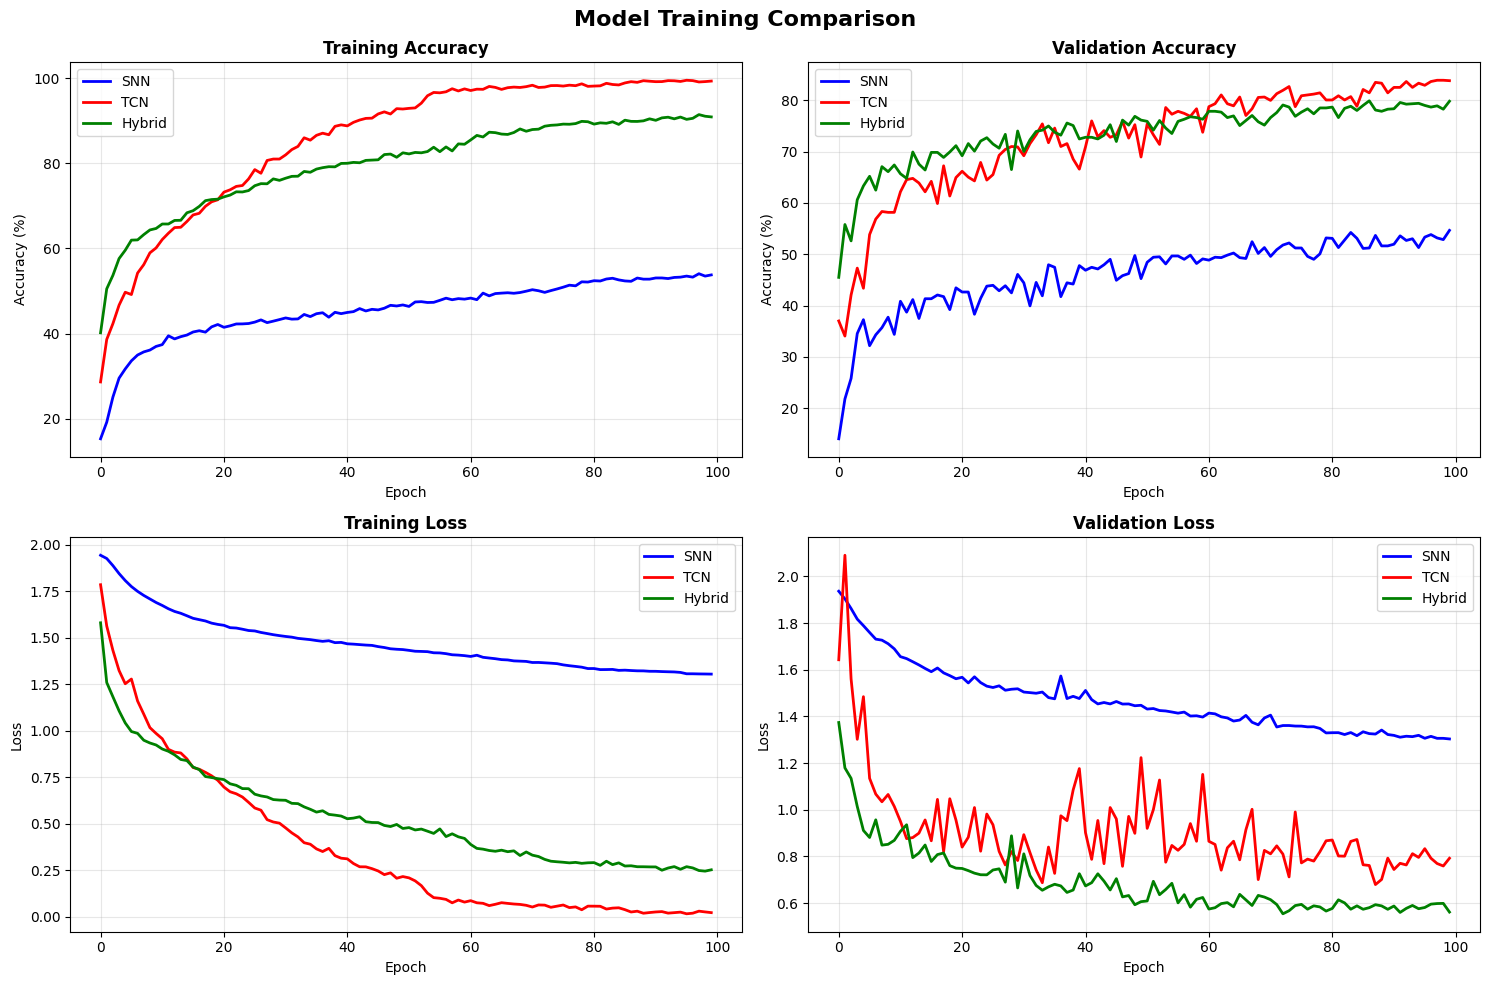


8. Plotting Test Accuracy Comparison...


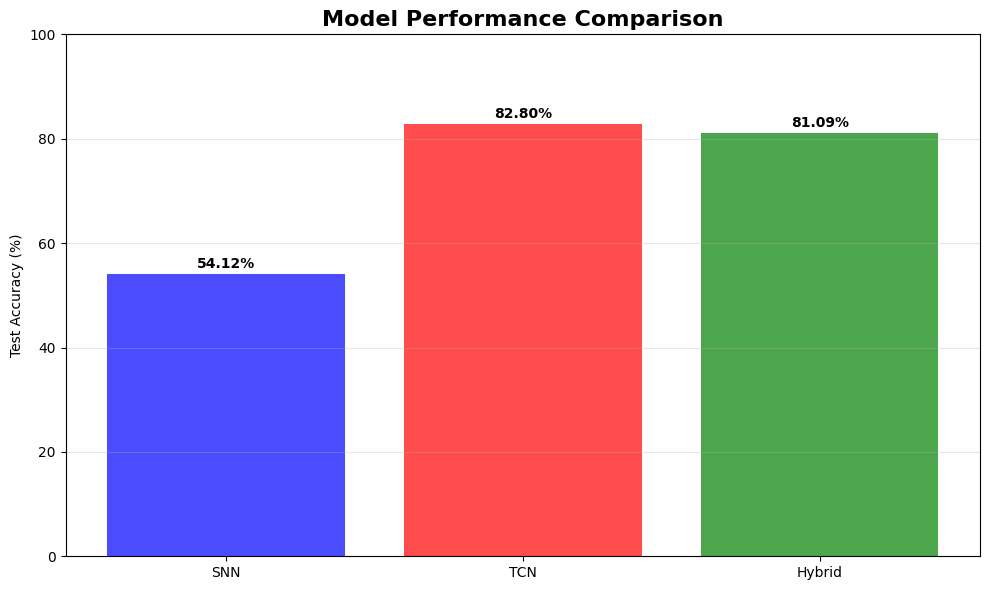


9. Confusion Matrices


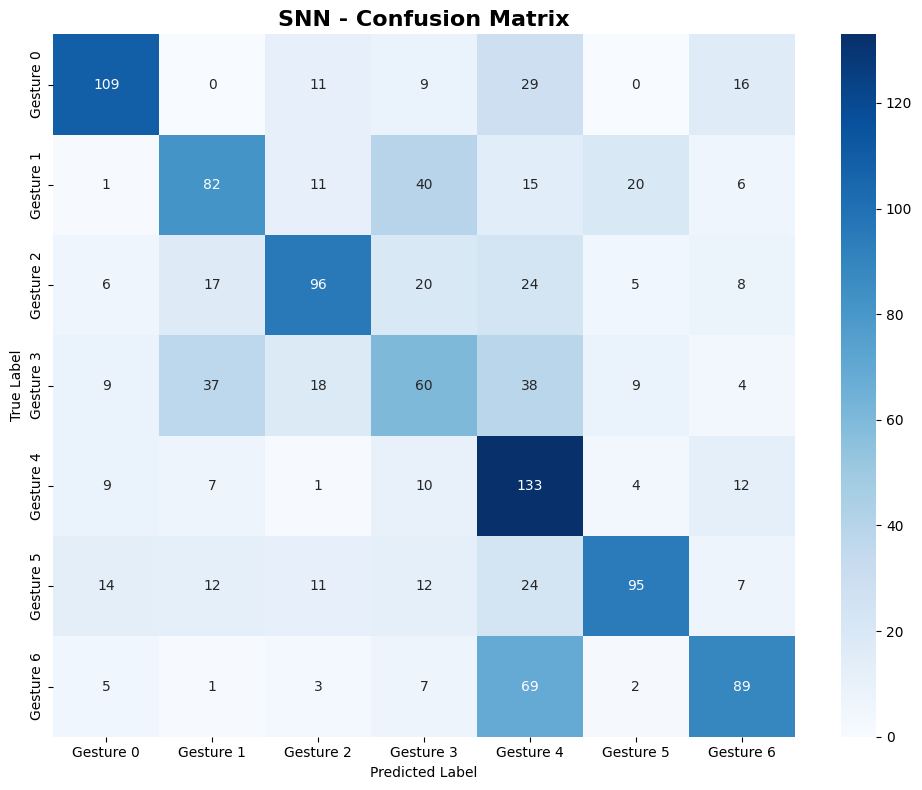

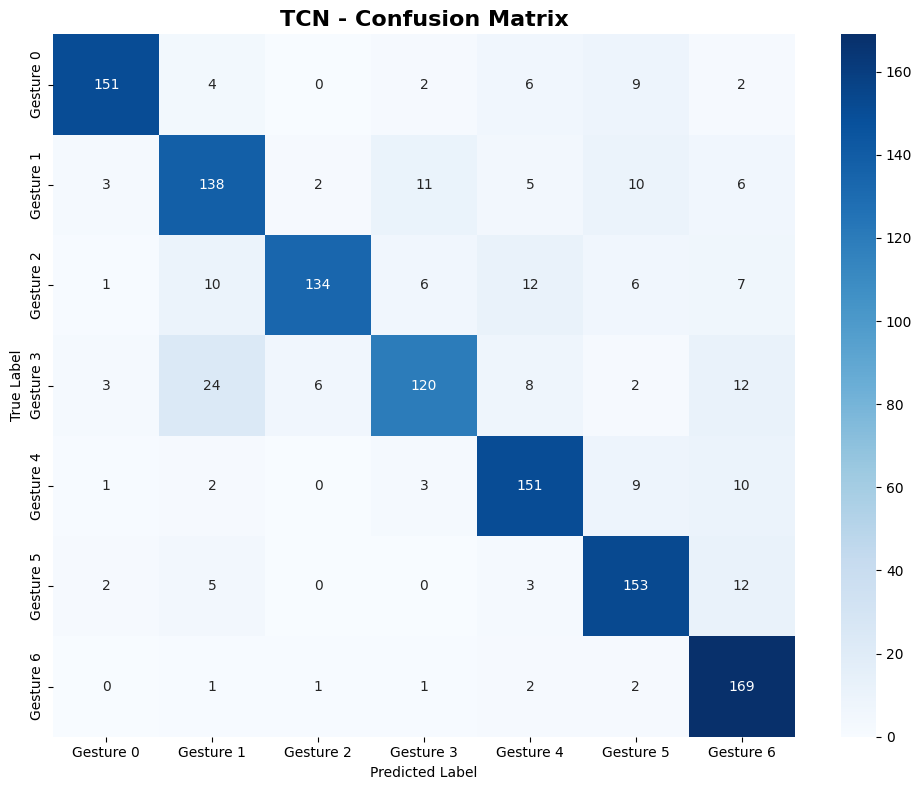

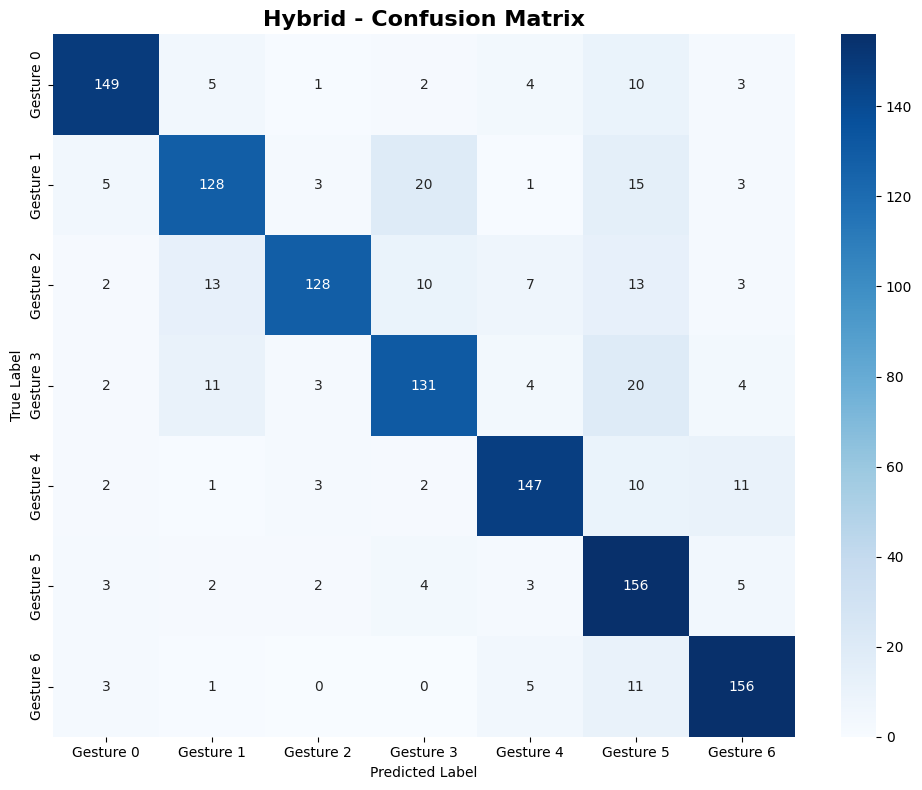

In [22]:
# 8. 학습 결과 시각화
print("\n7. Plotting Training History...")
plot_training_history(histories, ['SNN', 'TCN', 'Hybrid'])
print("\n8. Plotting Test Accuracy Comparison...")
plot_model_comparison_results(results)
print("\n9. Confusion Matrices")
for model_name, result in results.items():
    plot_confusion_matrix(result['targets'], result['preds'], class_names, model_name)


10. Visualizing Spikes (Hybrid Model)...


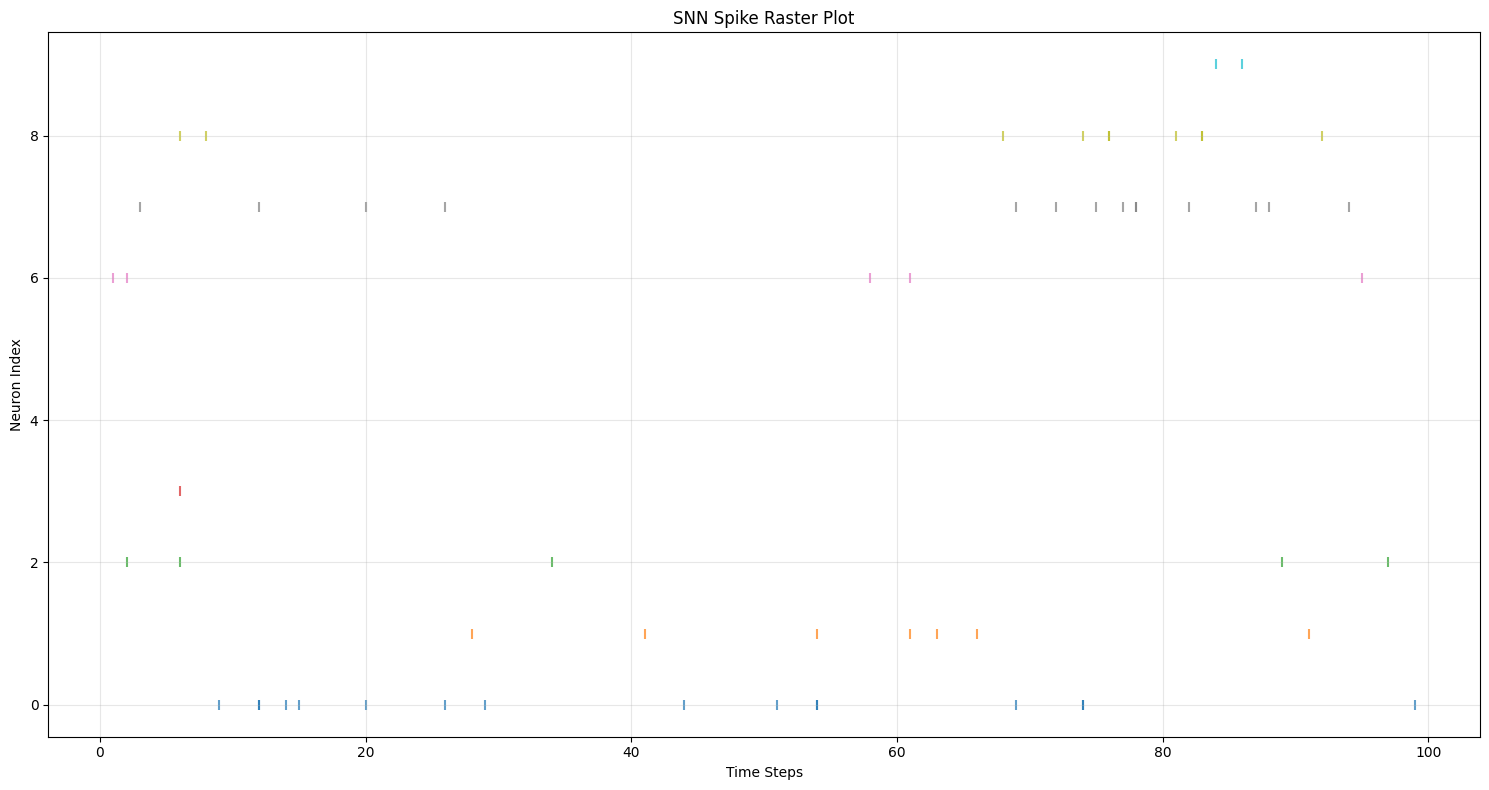

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (200,) and arg 1 with shape (200, 32).

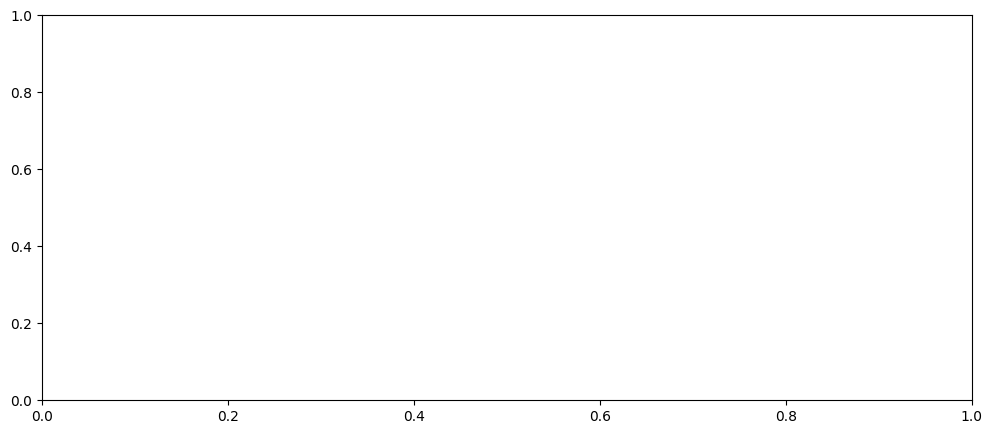

In [23]:
# 10. SNN Spike 시각화
print("\n10. Visualizing Spikes (Hybrid Model)...")
sample_input = torch.FloatTensor(X_test_scaled[:1])
visualize_snn_spikes(hybrid_model, sample_input)
print("\n=== All Done ===")

In [87]:
def visualize_snn_spikes2(model, sample_data, num_steps=200, num_neurons=10):
    """SNN 스파이크 시각화"""
    if not hasattr(model, 'snn'):
        print("Model doesn't have SNN component")
        return
    
    model.eval()
    with torch.no_grad():
        sample_data = sample_data.to(device)
        
        # Get spikes from SNN
        if hasattr(model, 'snn'):
            spikes = model.snn(sample_data[:1])  # First sample only
        else:
            # For pure SNN model
            spikes = model.snn(sample_data[:1])
        
        # spikes shape: (num_steps, 1, hidden_size)
        spike_data = spikes.squeeze(1).cpu().numpy()  # (num_steps, hidden_size)
        
        # spike_data: (T, N) 혹은 (B, T, N) 라고 가정 (마지막 축이 뉴런 축)
        arr = np.asarray(spike_data)
        if arr.ndim == 3:        # (B, T, N)
            firing_rates = arr.mean(axis=(0,1))   # -> (N,)
        elif arr.ndim == 2:      # (T, N)
            firing_rates = arr.mean(axis=0)       # -> (N,)
        else:
            raise ValueError(f"Unexpected spike_data shape: {arr.shape}")

      

        plt.figure(figsize=(15, 8))
   
        # Raster plot
        for neuron_idx in range(min(num_neurons, spike_data.shape[1])):
            spike_times = np.where(spike_data[:, neuron_idx] > 0.5)[0]
            plt.scatter(spike_times, [neuron_idx] * len(spike_times), 
                       marker='|', s=500, alpha=0.9, linewidths=5, color='black')
            
    
        plt.xlabel('Time Steps')
        plt.ylabel('Neuron Index')
        plt.title('SNN Spike Raster Plot')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    

        
        # Firing rate histogram
        # firing_rates = np.mean(spike_data, axis=0)
        plt.figure(figsize=(12, 5))
        plt.bar(range(len(firing_rates)), firing_rates, alpha=0.7)
        plt.xlabel('Neuron Index')
        plt.ylabel('Firing Rate')
        plt.title('Neuron Firing Rates')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()


10. Visualizing Spikes (Hybrid Model)...


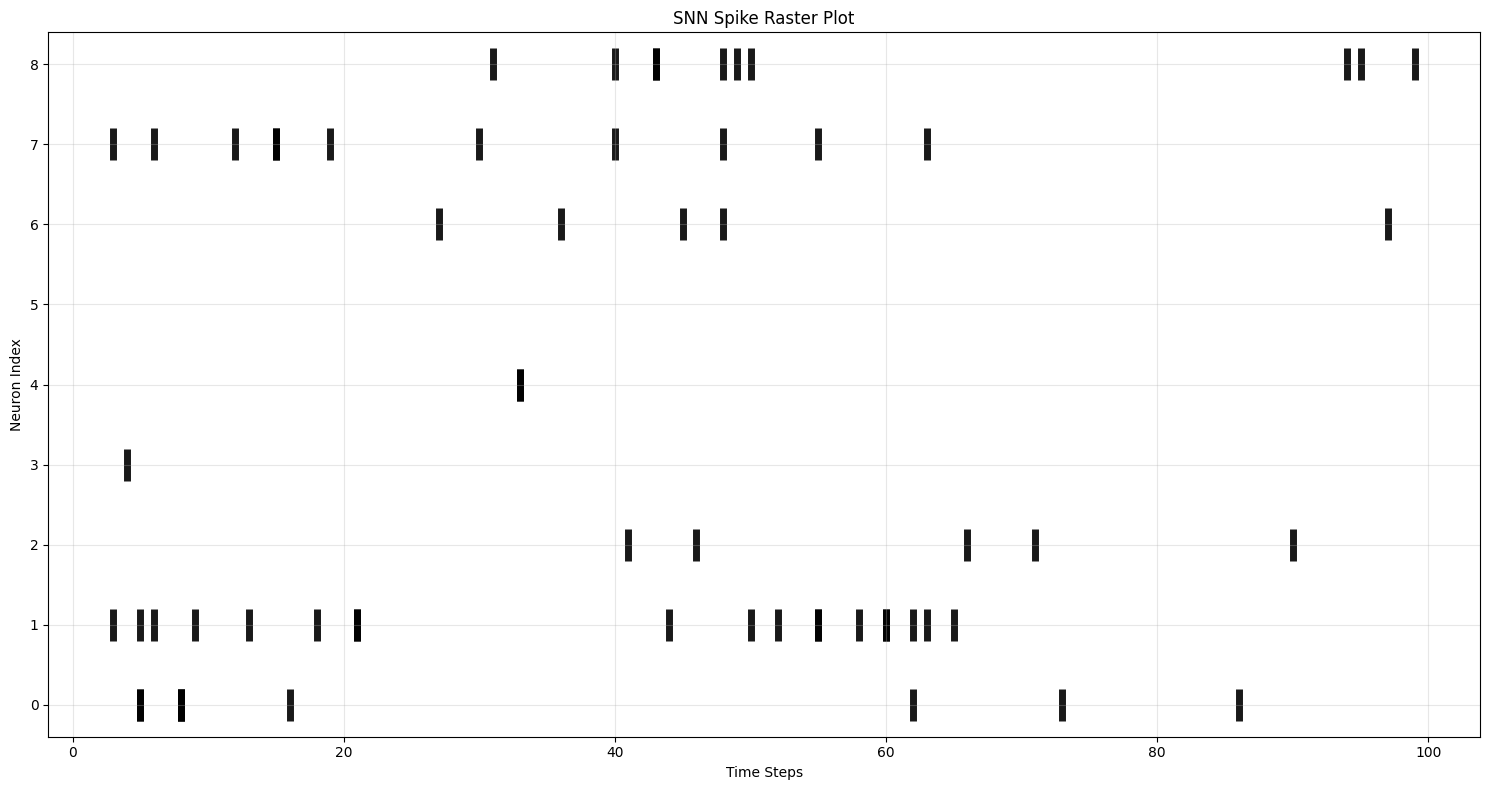

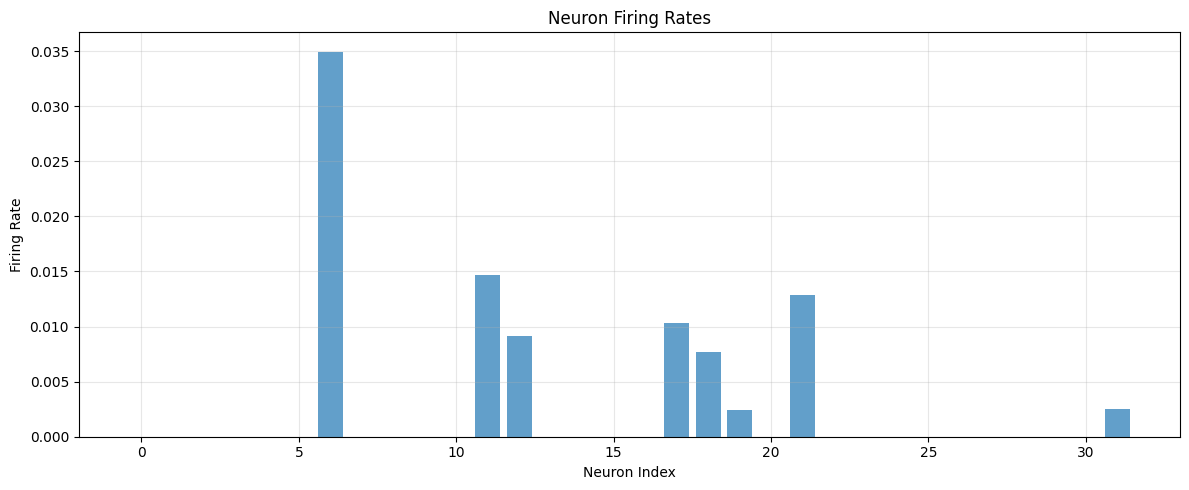


=== All Done ===


In [88]:
# 10. SNN Spike 시각화
print("\n10. Visualizing Spikes (Hybrid Model)...")
sample_input = torch.FloatTensor(X_test_scaled[:1])
visualize_snn_spikes2(hybrid_model, sample_input)
print("\n=== All Done ===")

In [80]:
def visualize_snn_spikes3(model, sample_data, num_steps=200, num_neurons=10):
    """SNN 스파이크 시각화"""
    if not hasattr(model, 'snn'):
        print("Model doesn't have SNN component")
        return
    
    model.eval()
    with torch.no_grad():
        sample_data = sample_data.to(device)
        
        # Get spikes from SNN
        if hasattr(model, 'snn'):
            spikes = model.snn(sample_data[:1])  # First sample only
        else:
            # For pure SNN model
            spikes = model.snn(sample_data[:1])
        
        # spikes shape: (num_steps, 1, hidden_size)
        spike_data = spikes.squeeze(1).cpu().numpy()  # (num_steps, hidden_size)
        
        # spike_data: (T, N) 혹은 (B, T, N) 라고 가정 (마지막 축이 뉴런 축)
        arr = np.asarray(spike_data)
        if arr.ndim == 3:        # (B, T, N)
            firing_rates = arr.mean(axis=(0,1))   # -> (N,)
        elif arr.ndim == 2:      # (T, N)
            firing_rates = arr.mean(axis=0)       # -> (N,)
        else:
            raise ValueError(f"Unexpected spike_data shape: {arr.shape}")

      

        plt.figure(figsize=(15, 8))
        
        # Raster plot
        for neuron_idx in range(min(num_neurons, spike_data.shape[1])):
            spike_times = np.where(spike_data[:, neuron_idx] > 0.5)[0]
            plt.scatter(spike_times, [neuron_idx] * len(spike_times), 
                       marker='|', s=50, alpha=0.7)
        
        plt.xlabel('Time Steps')
        plt.ylabel('Neuron Index')
        plt.title('SNN Spike Raster Plot')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
       # arr: (T, N) 또는 (B, T, N)면 먼저 (T, N)으로 평균
        arr2d = arr.mean(axis=0) if arr.ndim==3 else arr  # -> (T, N)
        plt.figure(figsize=(12,5))
        plt.imshow(arr2d, aspect='auto', origin='lower')
        plt.xlabel('Neuron Index'); plt.ylabel('Time'); plt.title('Spike activity (time × neuron)')
        plt.colorbar(label='Spike/Rate')
        plt.tight_layout()
        plt.show()


10. Visualizing Spikes (Hybrid Model)...


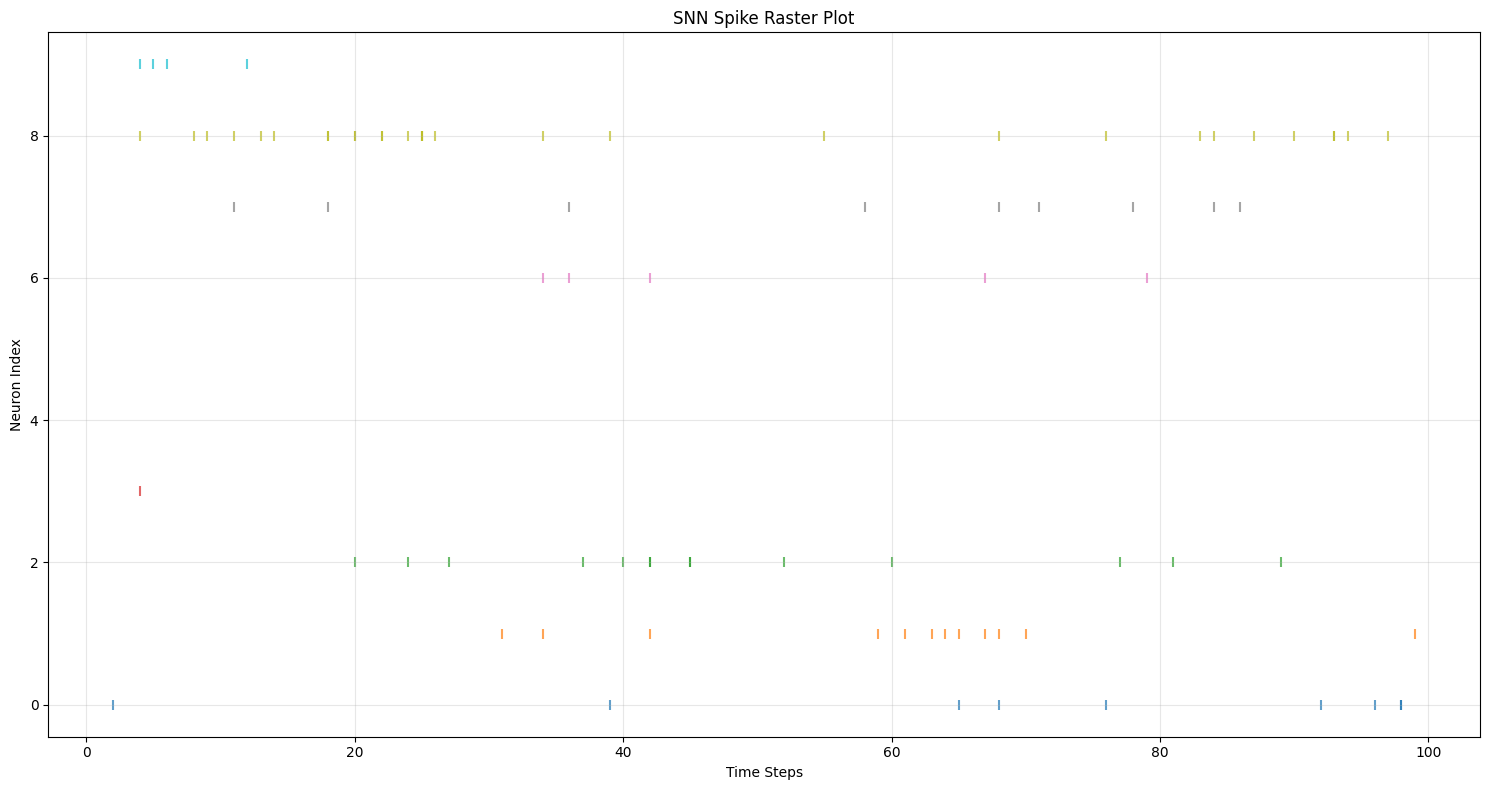

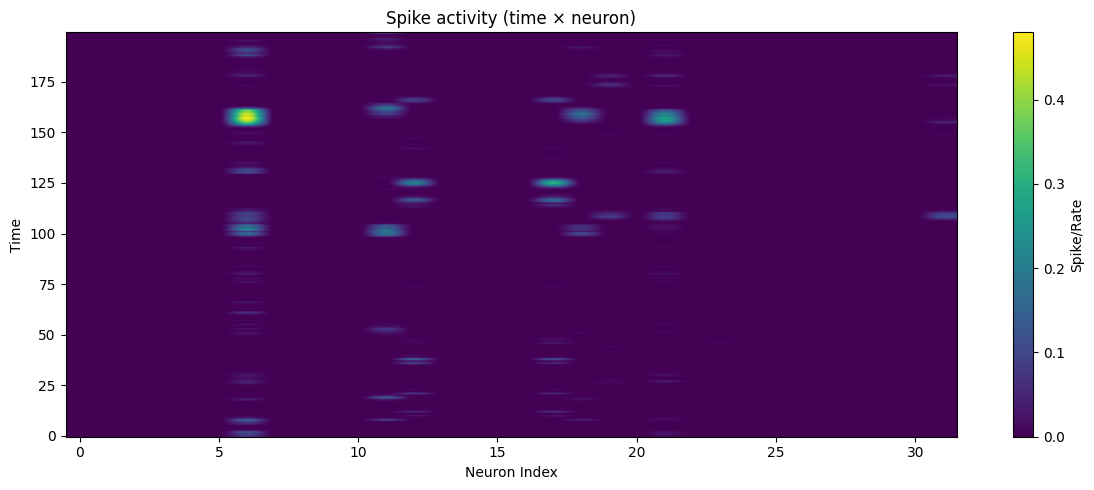


=== All Done ===


In [75]:
# 10. SNN Spike 시각화
print("\n10. Visualizing Spikes (Hybrid Model)...")
sample_input = torch.FloatTensor(X_test_scaled[:1])
visualize_snn_spikes3(hybrid_model, sample_input)
print("\n=== All Done ===")

In [42]:
def visualize_snn_spikes2(
    model,
    sample_data,
    num_steps=200,
    num_neurons=10,
    threshold=0.5,
    raster_size=(20, 10),
    hist_size=(16, 6),
    dpi=150,
    show_heatmap=False,
    save_prefix=None,   # 예: "runs/exp1/spikes" -> png 파일로 저장
):
    """SNN 스파이크 시각화 (크기/가독성/히트맵/저장 옵션 추가)"""
    if not hasattr(model, 'snn'):
        print("Model doesn't have SNN component")
        return

    model.eval()
    with torch.no_grad():
        sample_data = sample_data.to(device)

        # Get spikes from SNN (첫 샘플만)
        spikes = model.snn(sample_data[:1])  # 기대 shape: (T, 1, N) 또는 (T, N)
        spike_data = spikes.squeeze(1).detach().cpu().numpy()  # -> (T, N) 기대

       
       

        # --- 시간 길이 제한 (num_steps 적용) ---
        arr = np.asarray(spike_data)
        if arr.ndim == 3 and arr.shape[-1] >= 1:
            # (S, T, N) or (B, T, N) 형태 가정 → 앞축 평균으로 (T, N)
            arr2d = arr.mean(axis=0)         # -> (200, 32)
        elif arr.ndim == 2:
            arr2d = arr                       # -> (T, N)
        else:
            # 가장 일반화: 마지막 축 제외 모두를 타임축으로 펼치기
            arr2d = arr.reshape(-1, arr.shape[-1])  # -> (T*, N)

        T, N = arr2d.shape
        T_show = min(num_steps, T)
        N_show = min(num_neurons, N)
        spike_data_t = arr2d[:T_show, :N_show]


        # --- 뉴런별 firing rate (1D) ---
        firing_rates = spike_data_t.mean(axis=0)  # (N_show,)

        # ---------- Raster Plot ----------
        plt.figure(figsize=raster_size, dpi=dpi)
        # eventplot이 scatter보다 가독성/성능 좋음
        spike_times_list = [np.where(spike_data_t[:, i] > threshold)[0] for i in range(N_show)]
        plt.eventplot(
            spike_times_list,
            lineoffsets=np.arange(N_show),
            linelengths=0.9,     # 각 스파이크 선 길이
            linewidths=2.0,      # 선 굵기
        )
        plt.xlim(0, T_show)
        plt.ylim(-0.5, N_show - 0.5)
        plt.xlabel('Time Steps', fontsize=16)
        plt.ylabel('Neuron Index', fontsize=16)
        plt.title('SNN Spike Raster Plot', fontsize=18)
        plt.xticks(fontsize=12); plt.yticks(fontsize=12)
        plt.grid(True, alpha=0.25)
        plt.tight_layout()
        if save_prefix is not None:
            plt.savefig(f"{save_prefix}_raster.png", bbox_inches='tight')
        plt.show()

        # ---------- (옵션) Heatmap ----------
        if show_heatmap:
            plt.figure(figsize=raster_size, dpi=dpi)
            plt.imshow(spike_data_t.T, aspect='auto', origin='lower')
            plt.xlabel('Time Steps', fontsize=16)
            plt.ylabel('Neuron Index', fontsize=16)
            plt.title('Spike Activity Heatmap', fontsize=18)
            plt.colorbar(label='Spike/Activation')
            plt.tight_layout()
            if save_prefix is not None:
                plt.savefig(f"{save_prefix}_heatmap.png", bbox_inches='tight')
            plt.show()

        # ---------- Firing Rate Bar ----------
        plt.figure(figsize=hist_size, dpi=dpi)
        x = np.arange(N_show)
        plt.bar(x, firing_rates, alpha=0.8)
        plt.xlabel('Neuron Index', fontsize=16)
        plt.ylabel('Mean Firing Rate', fontsize=16)
        plt.title('Neuron Firing Rates', fontsize=18)
        plt.xticks(x, x, fontsize=12)
        plt.yticks(fontsize=12)
        plt.grid(True, axis='y', alpha=0.3)
        plt.tight_layout()
        if save_prefix is not None:
            plt.savefig(f"{save_prefix}_rates.png", bbox_inches='tight')
        plt.show()

        return {"firing_rates": firing_rates, "T": T_show, "N": N_show}


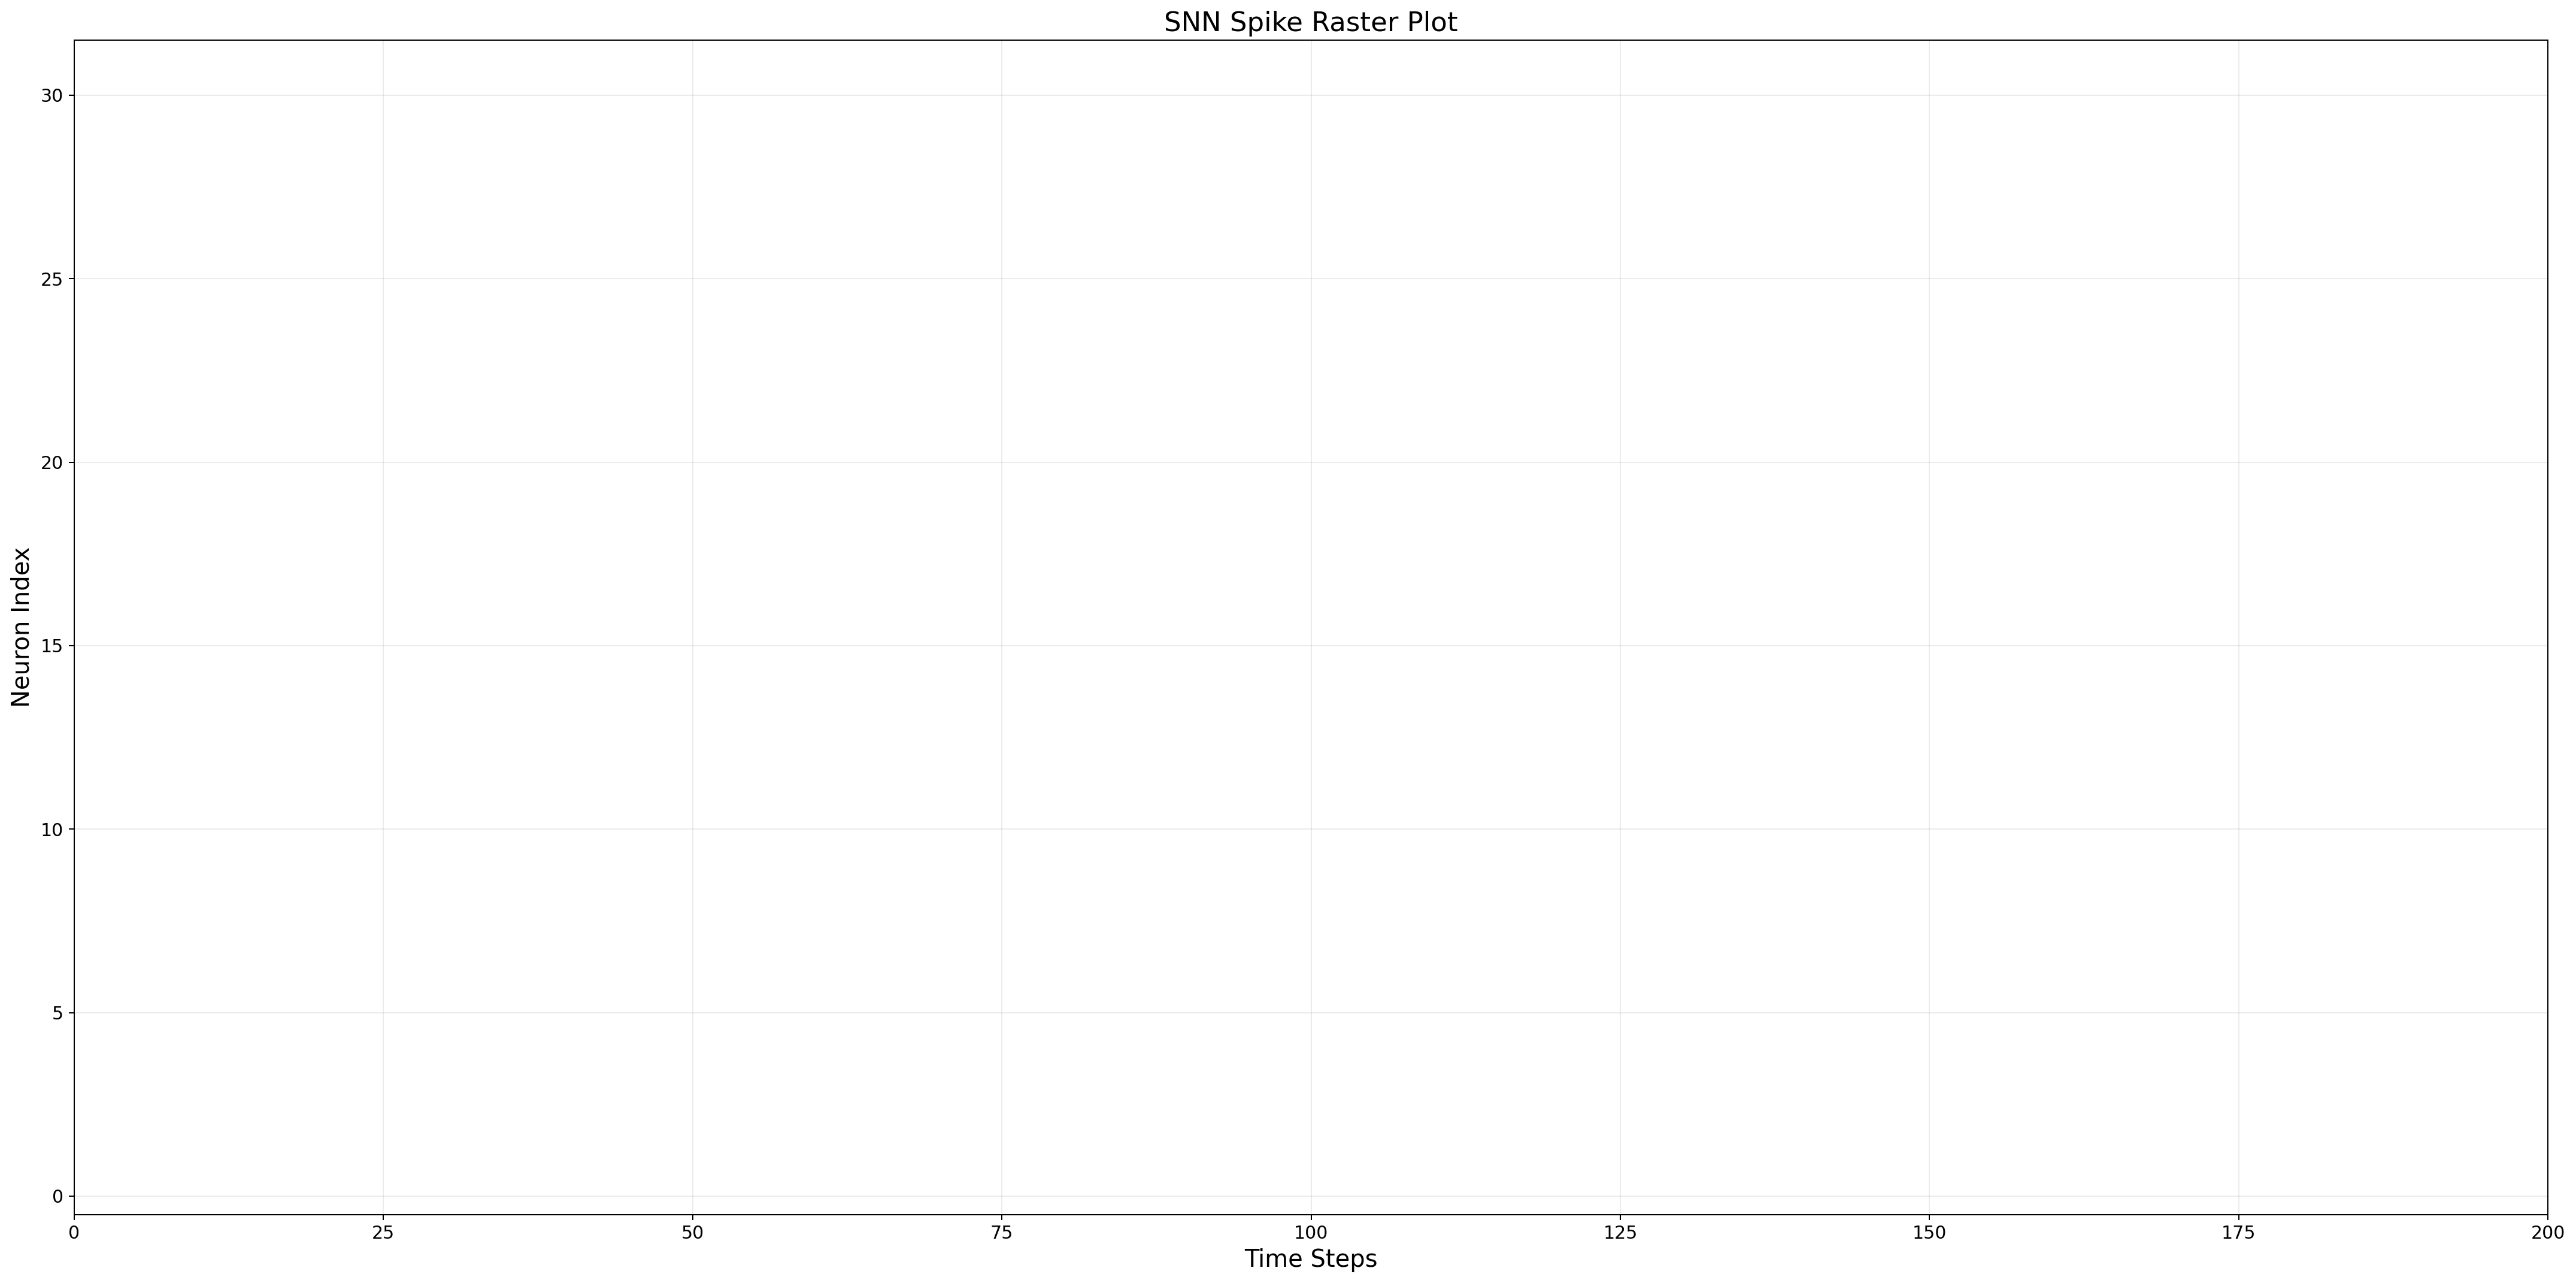

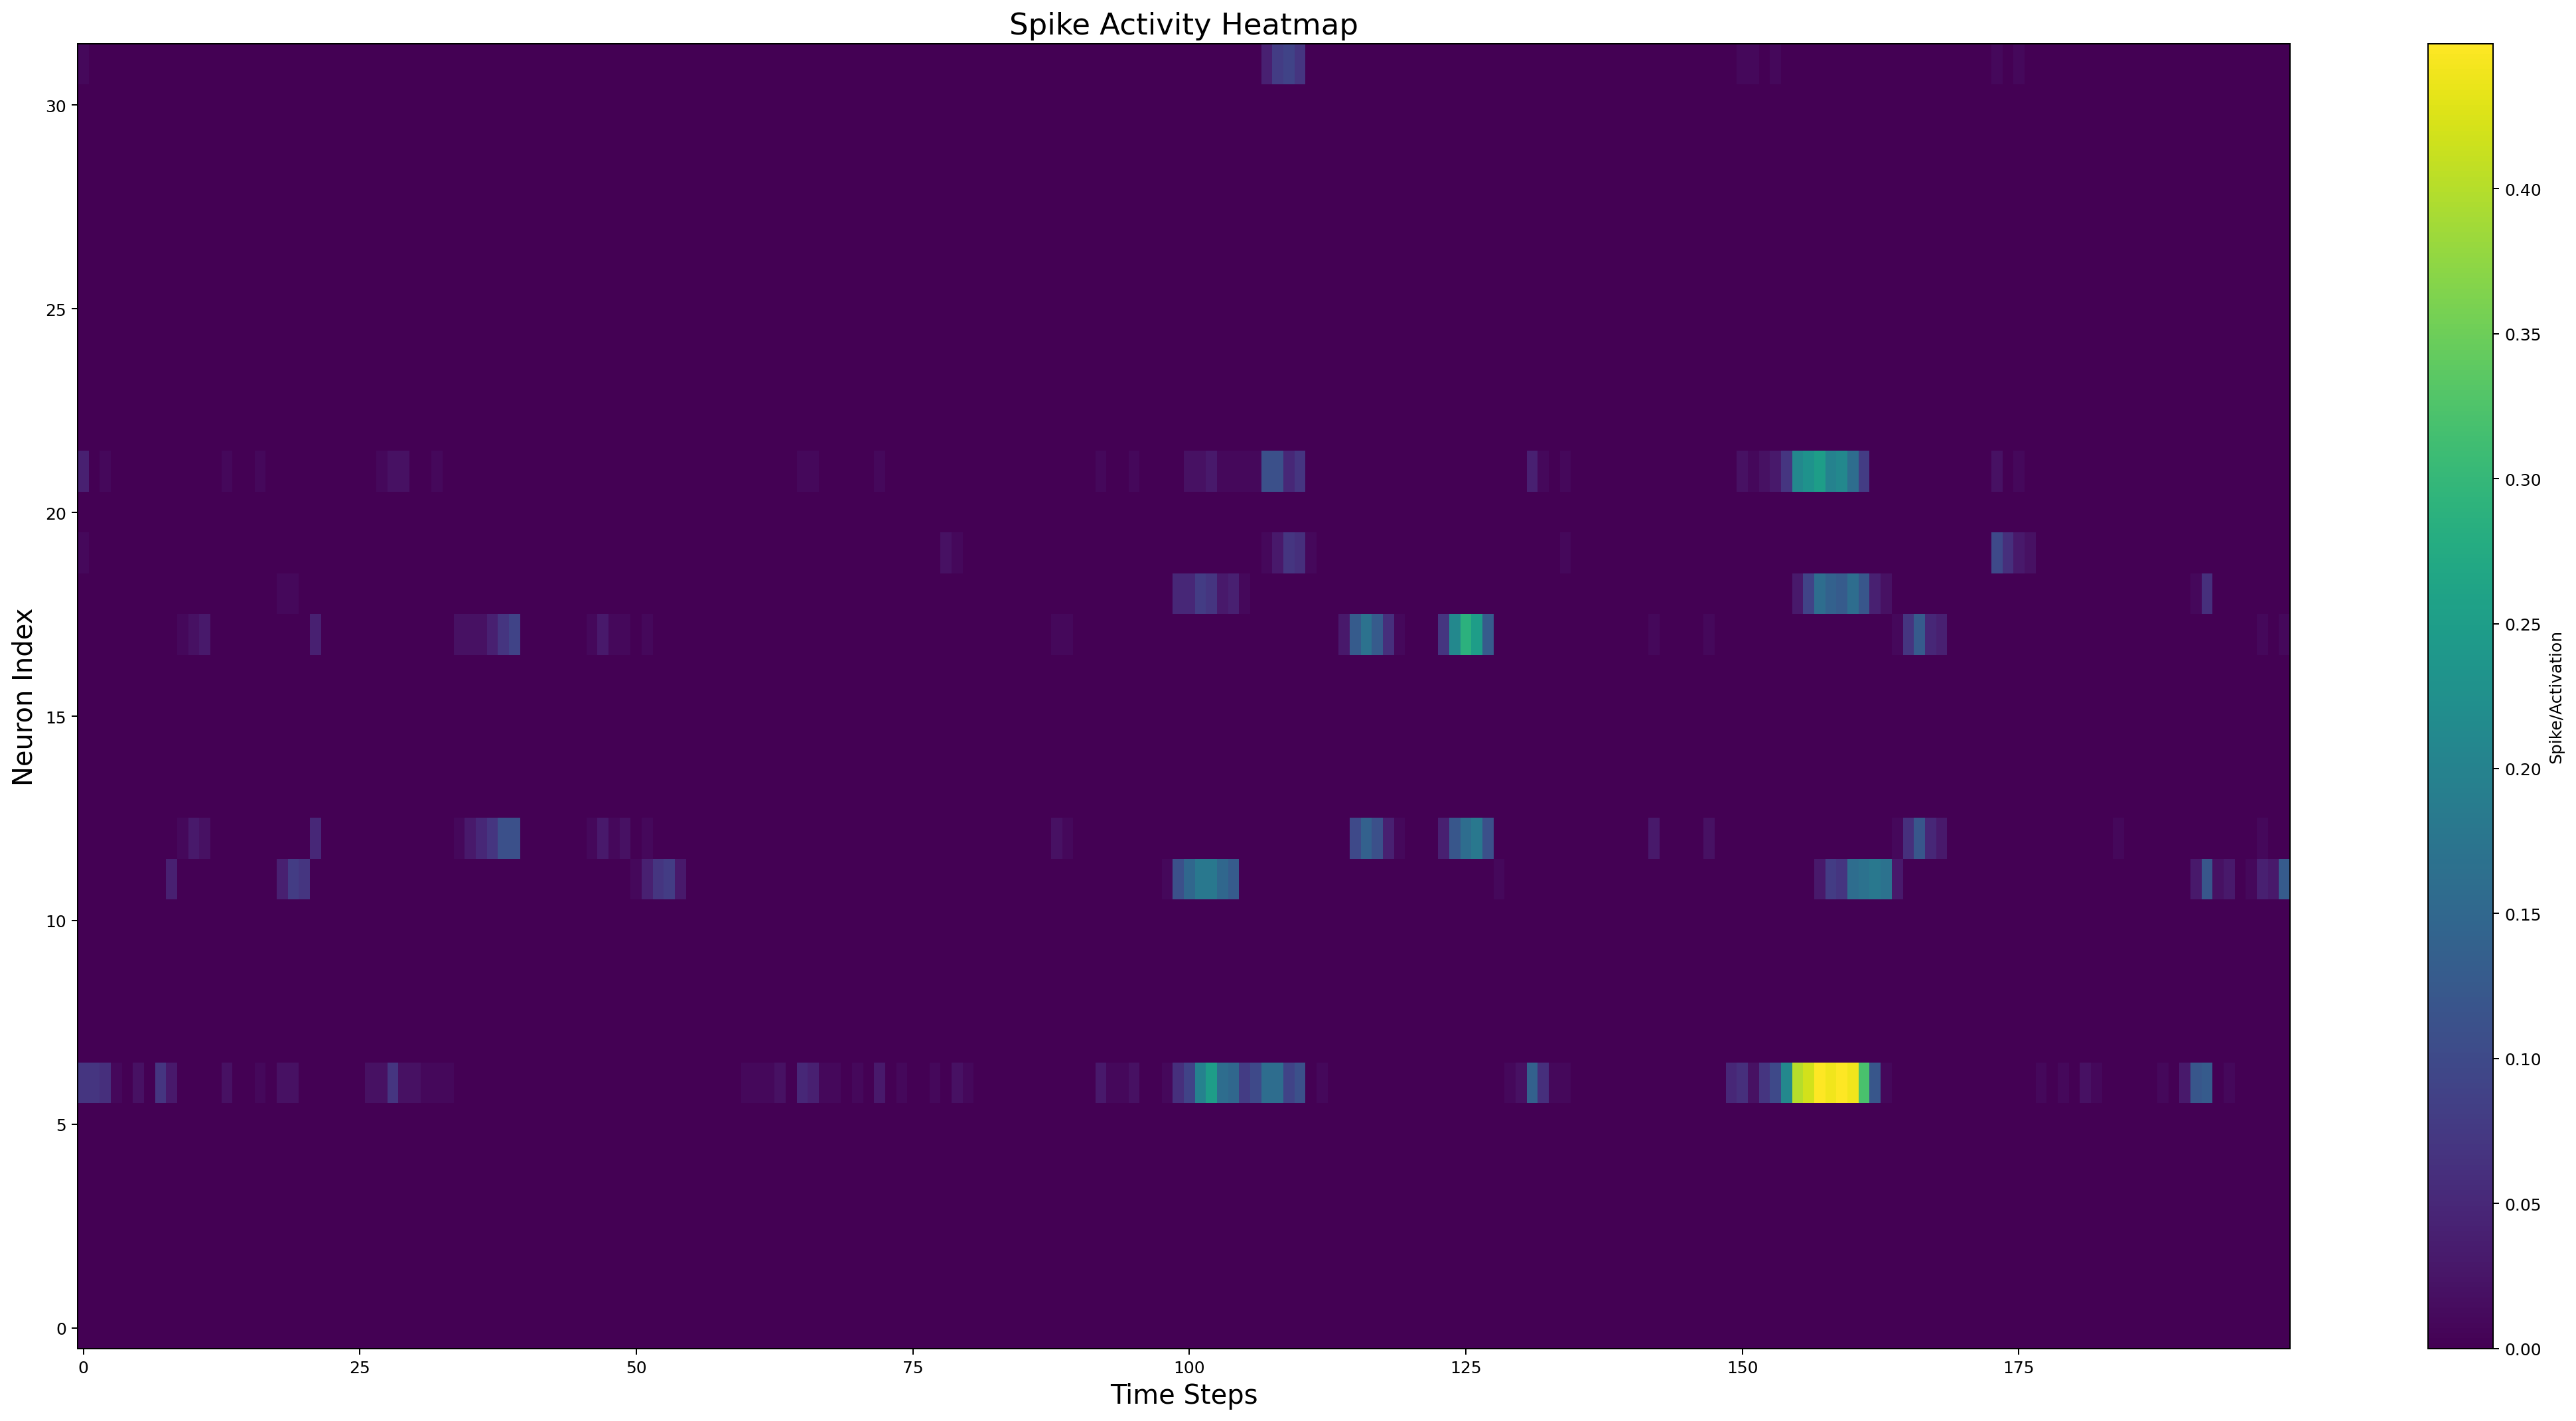

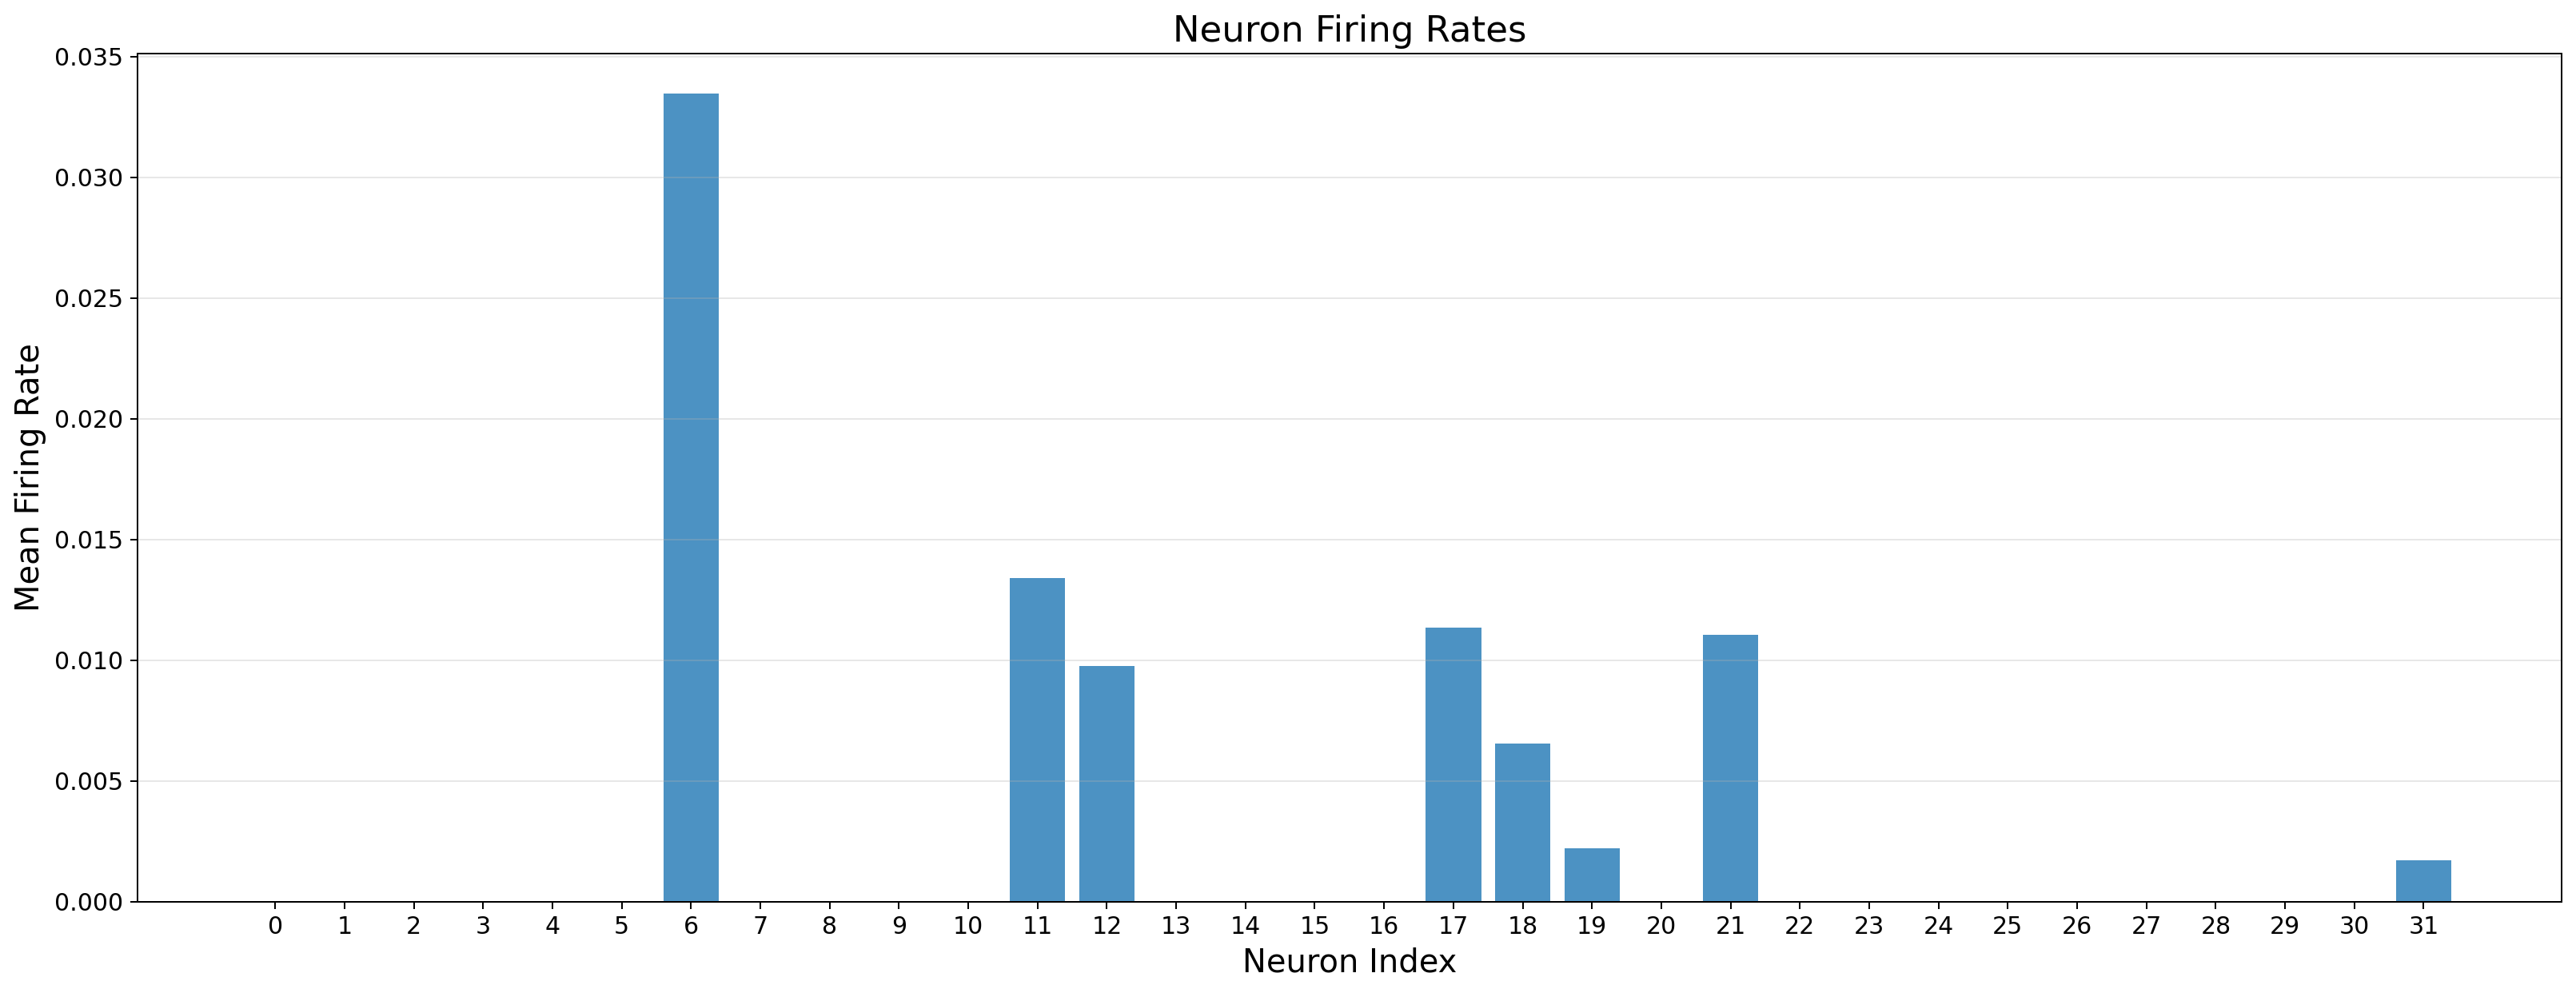

In [44]:
out = visualize_snn_spikes2(
    hybrid_model,
    sample_input,          # shape: (B, T, C, ...)라면 [:1]만 내부에서 사용
    num_steps=300,         # 더 길게 보고 싶으면 늘리기
    num_neurons=32,        # 더 많은 뉴런 표시
    threshold=0.5,         # 스파이크 판정 임계값
    raster_size=(24, 12),  # 그림 크게
    hist_size=(18, 7),
    dpi=180,               # 해상도 업
    show_heatmap=True,     # 히트맵도 같이 보기
    save_prefix="runs/exp1/spikes"
)


In [71]:
def visualize_snn_spikes4(
    model,
    sample_data,
    num_steps=200,
    num_neurons=32,
    *,
    threshold=0.5,
    time_axis=0,        # <- 당신 케이스: (time, neuron/window, batch)
    neuron_axis=1,
    batch_axis=2,
    batch_reduce="first",   # "first" or "mean"
    raster_size=(20, 10),
    hist_size=(16, 6),
    dpi=300,
    linewidth=1.6,
    linelength=0.9,
    show_heatmap=False,
    save_prefix=None,   # 예: "runs/exp1/spikes" -> 파일 3개 저장
    title_suffix="(Hybrid TCN–SNN)"
):
    """
    논문용 SNN 스파이크 시각화.
    spikes 입력 형태가 다양해도 축 지정으로 처리.
    """
    import numpy as np
    import torch
    import matplotlib.pyplot as plt

    assert hasattr(model, 'snn'), "Model doesn't have SNN component"

    model.eval()
    with torch.no_grad():
        x = sample_data.to(next(model.parameters()).device)

        # --- 스파이크 추출 (첫 샘플만 통과) ---
        spikes = model.snn(x[:1])
        arr = spikes.detach().cpu().numpy()

    # ---------- 축 정리 ----------
    # 표준형으로 재배치: (T, N, B?) 순서가 되도록 transpose
    # 현재 인덱스(time_axis, neuron_axis, batch_axis)를 0,1,2로 보정
    # 배치축이 존재하지 않으면 batch_axis=None 처리
    axes = [time_axis, neuron_axis]
    has_batch = (batch_axis is not None) and (batch_axis < arr.ndim)
    if has_batch:
        axes.append(batch_axis)

    # transpose to put (time, neuron, batch?) in front
    perm = axes + [i for i in range(arr.ndim) if i not in axes]
    arr = np.transpose(arr, perm)

    # 이제 arr.shape = (T, N, B, ...extras)
    # extras가 있으면 전부 시간축으로 펼쳐버림
    if arr.ndim > 3:
        T, N = arr.shape[0], arr.shape[1]
        arr = arr.reshape(T, N, -1)  # (T, N, B*extras)

    # 배치 축 정리
    if arr.ndim == 3:
        if batch_reduce == "first":
            arr2d = arr[:, :, 0]         # (T, N)
        elif batch_reduce == "mean":
            arr2d = arr.mean(axis=2)     # (T, N)
        else:
            raise ValueError("batch_reduce must be 'first' or 'mean'")
    elif arr.ndim == 2:
        arr2d = arr
    else:
        raise ValueError(f"Unexpected spikes shape after transpose: {arr.shape}")

    # 시간/뉴런 수 제한
    T, N = arr2d.shape
    T_show = min(num_steps, T)
    N_show = min(num_neurons, N)
    spike_data_t = arr2d[:T_show, :N_show]

    # ---------- 통계 (스파스성/발화율) ----------
    firing_rates = spike_data_t.mean(axis=0)               # (N_show,)
    spike_counts = (spike_data_t > threshold).sum(axis=0)  # (N_show,)
    total_spikes = (spike_data_t > threshold).sum()
    sparsity = 1.0 - (total_spikes / spike_data_t.size)

    # ---------- Raster Plot ----------
    plt.figure(figsize=raster_size, dpi=dpi)
    spike_times_list = [np.where(spike_data_t[:, i] > threshold)[0] for i in range(N_show)]
    colors = plt.cm.tab20(np.linspace(0, 1, max(3, N_show)))  # 고정 팔레트
    plt.eventplot(
        spike_times_list,
        lineoffsets=np.arange(N_show),
        linewidths=linewidth,
        linelengths=linelength,
        colors=colors[:N_show]
    )
    plt.xlim(0, T_show)
    plt.ylim(-0.5, N_show - 0.5)
    plt.xlabel('Time Steps', fontsize=16)
    plt.ylabel('Neuron Index', fontsize=16)
    plt.title(f'SNN Spike Raster Plot {title_suffix}', fontsize=18)
    plt.xticks(fontsize=13); plt.yticks(fontsize=13)
    plt.grid(True, axis='x', alpha=0.25)
    plt.tight_layout()
    if save_prefix:
        plt.savefig(f"{save_prefix}_raster.png", bbox_inches='tight', dpi=dpi)
    plt.show()

    # ---------- (옵션) Heatmap ----------
    if show_heatmap:
        plt.figure(figsize=raster_size, dpi=dpi)
        plt.imshow(spike_data_t.T, aspect='auto', origin='lower')
        plt.xlabel('Time Steps', fontsize=16)
        plt.ylabel('Neuron Index', fontsize=16)
        plt.title(f'Spike Activity Heatmap {title_suffix}', fontsize=18)
        plt.colorbar(label='Spike/Activation')
        plt.tight_layout()
        if save_prefix:
            plt.savefig(f"{save_prefix}_heatmap.png", bbox_inches='tight', dpi=dpi)
        plt.show()

    # ---------- Firing Rate Bar ----------
    plt.figure(figsize=hist_size, dpi=dpi)
    x = np.arange(N_show)
    plt.bar(x, firing_rates, alpha=0.85)
    plt.xlabel('Neuron Index', fontsize=16)
    plt.ylabel('Mean Firing Rate', fontsize=16)
    plt.title(f'Neuron Firing Rates {title_suffix}', fontsize=18)
    plt.xticks(x, x, fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    if save_prefix:
        plt.savefig(f"{save_prefix}_rates.png", bbox_inches='tight', dpi=dpi)
    plt.show()

    return {
        "T": T_show,
        "N": N_show,
        "firing_rates": firing_rates,
        "spike_counts": spike_counts,
        "sparsity": float(sparsity),      # 1에 가까울수록 스파스
        "total_spikes": int(total_spikes)
    }


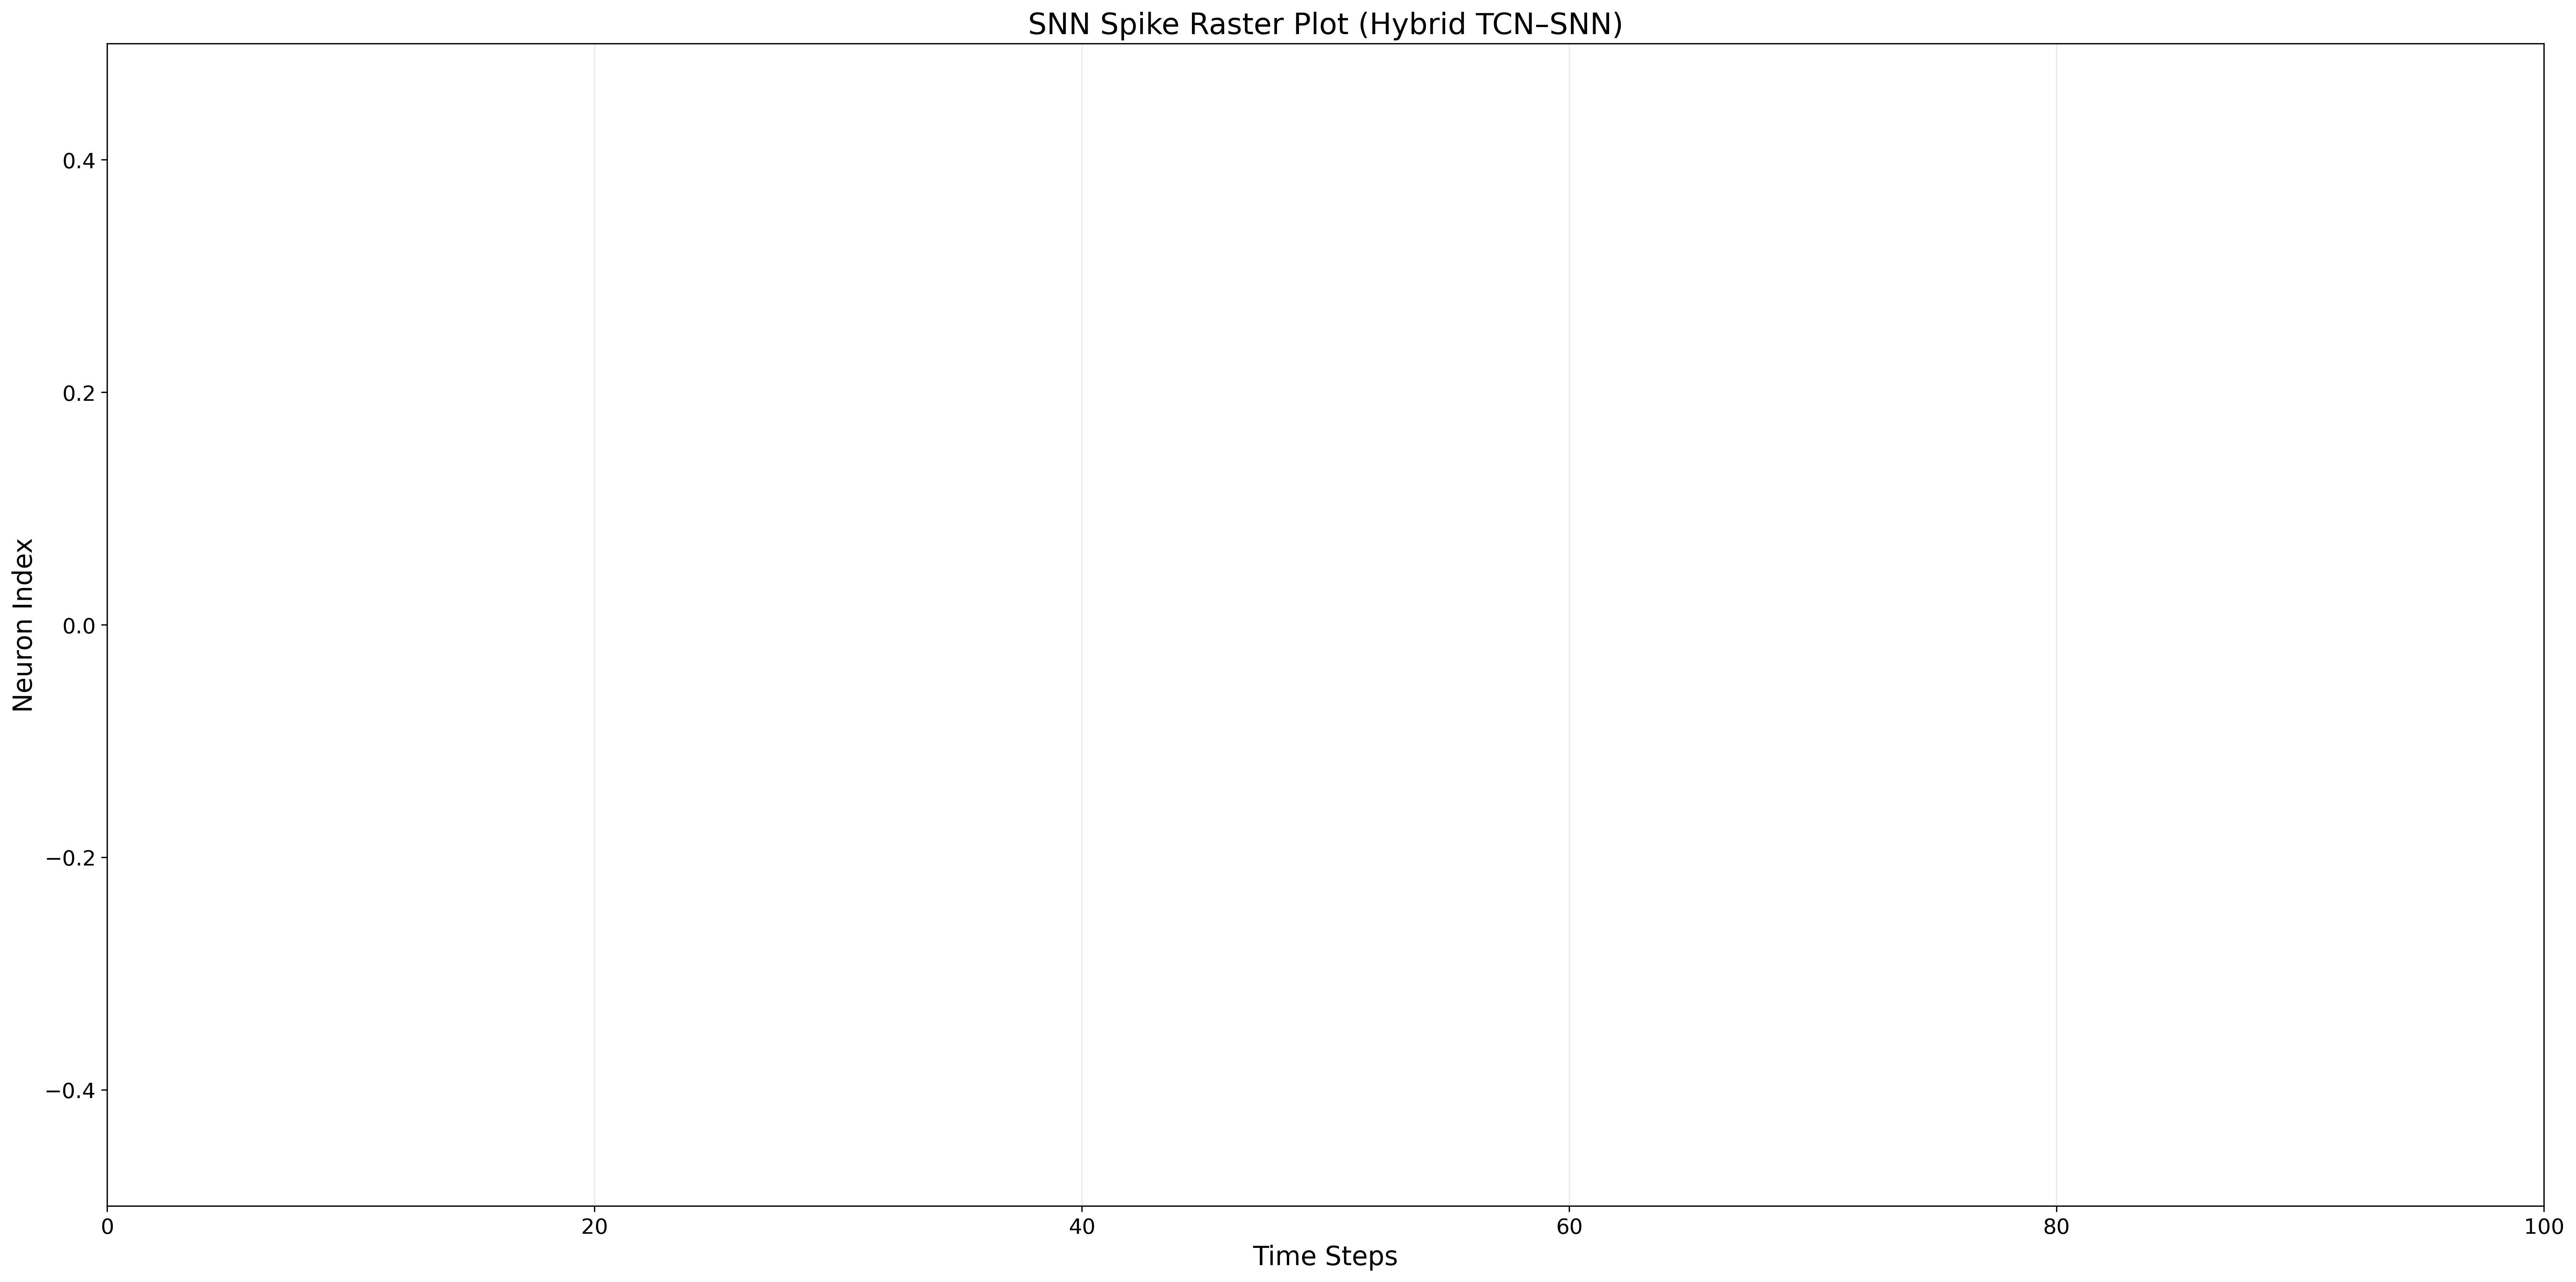

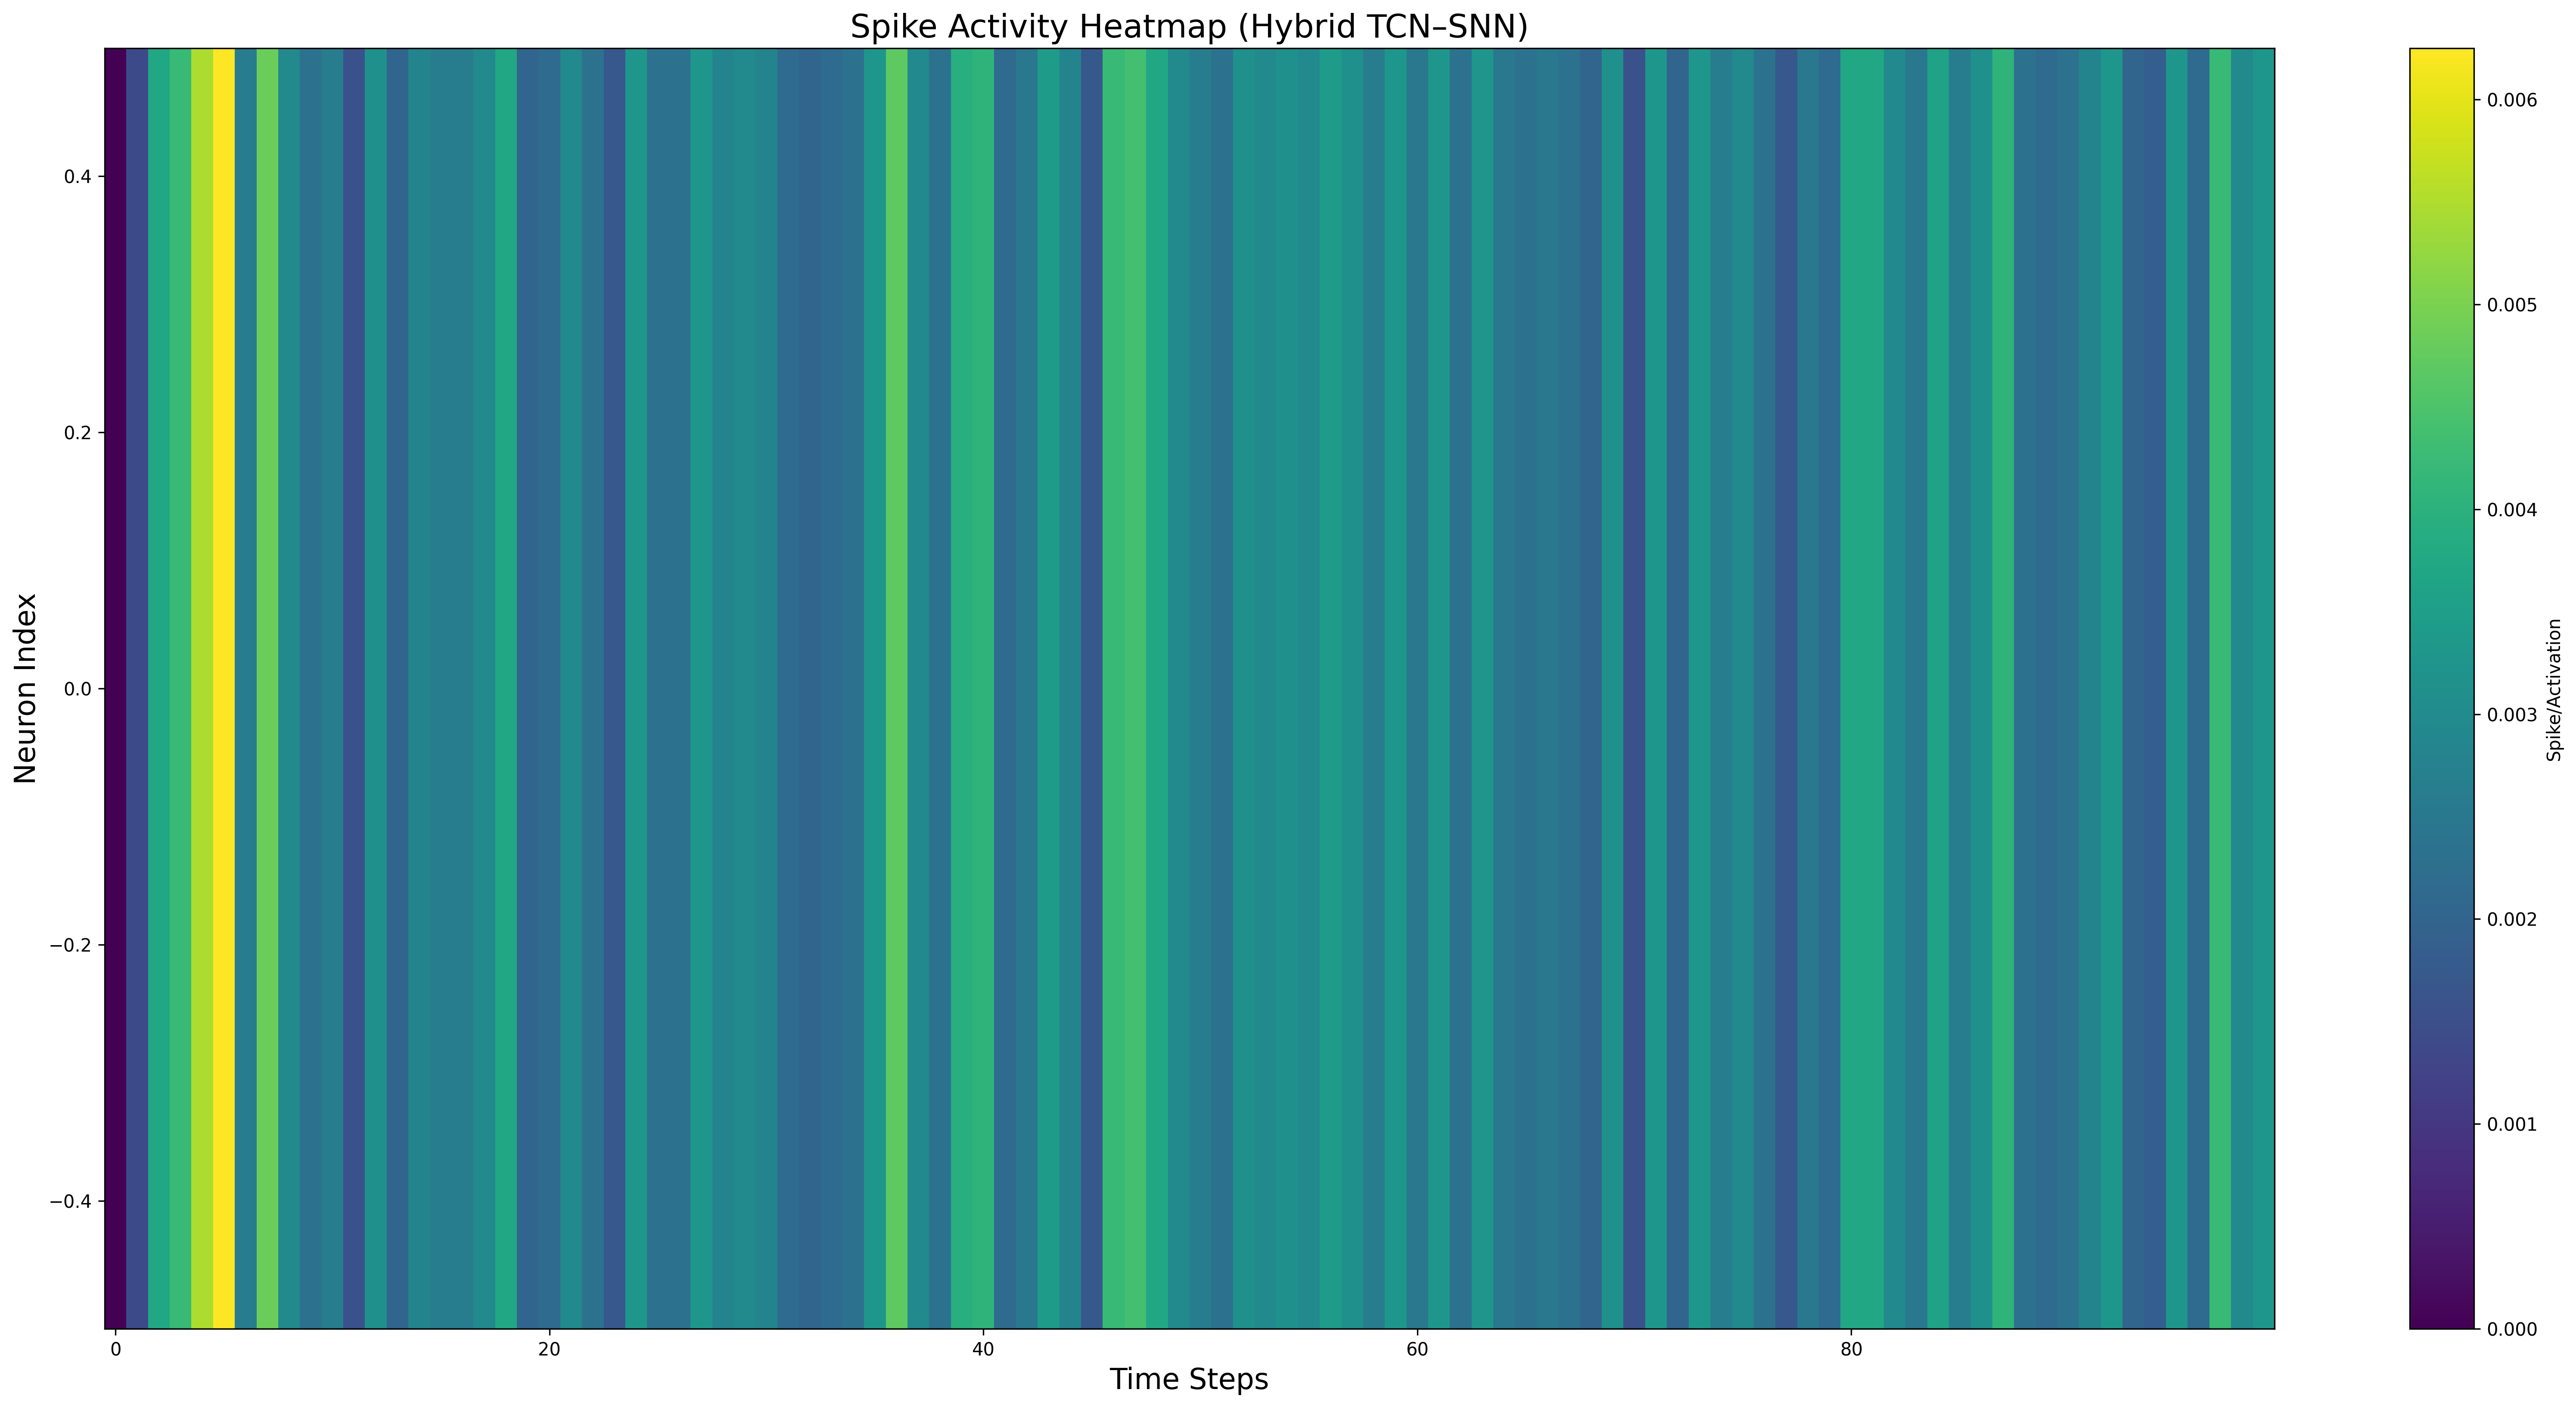

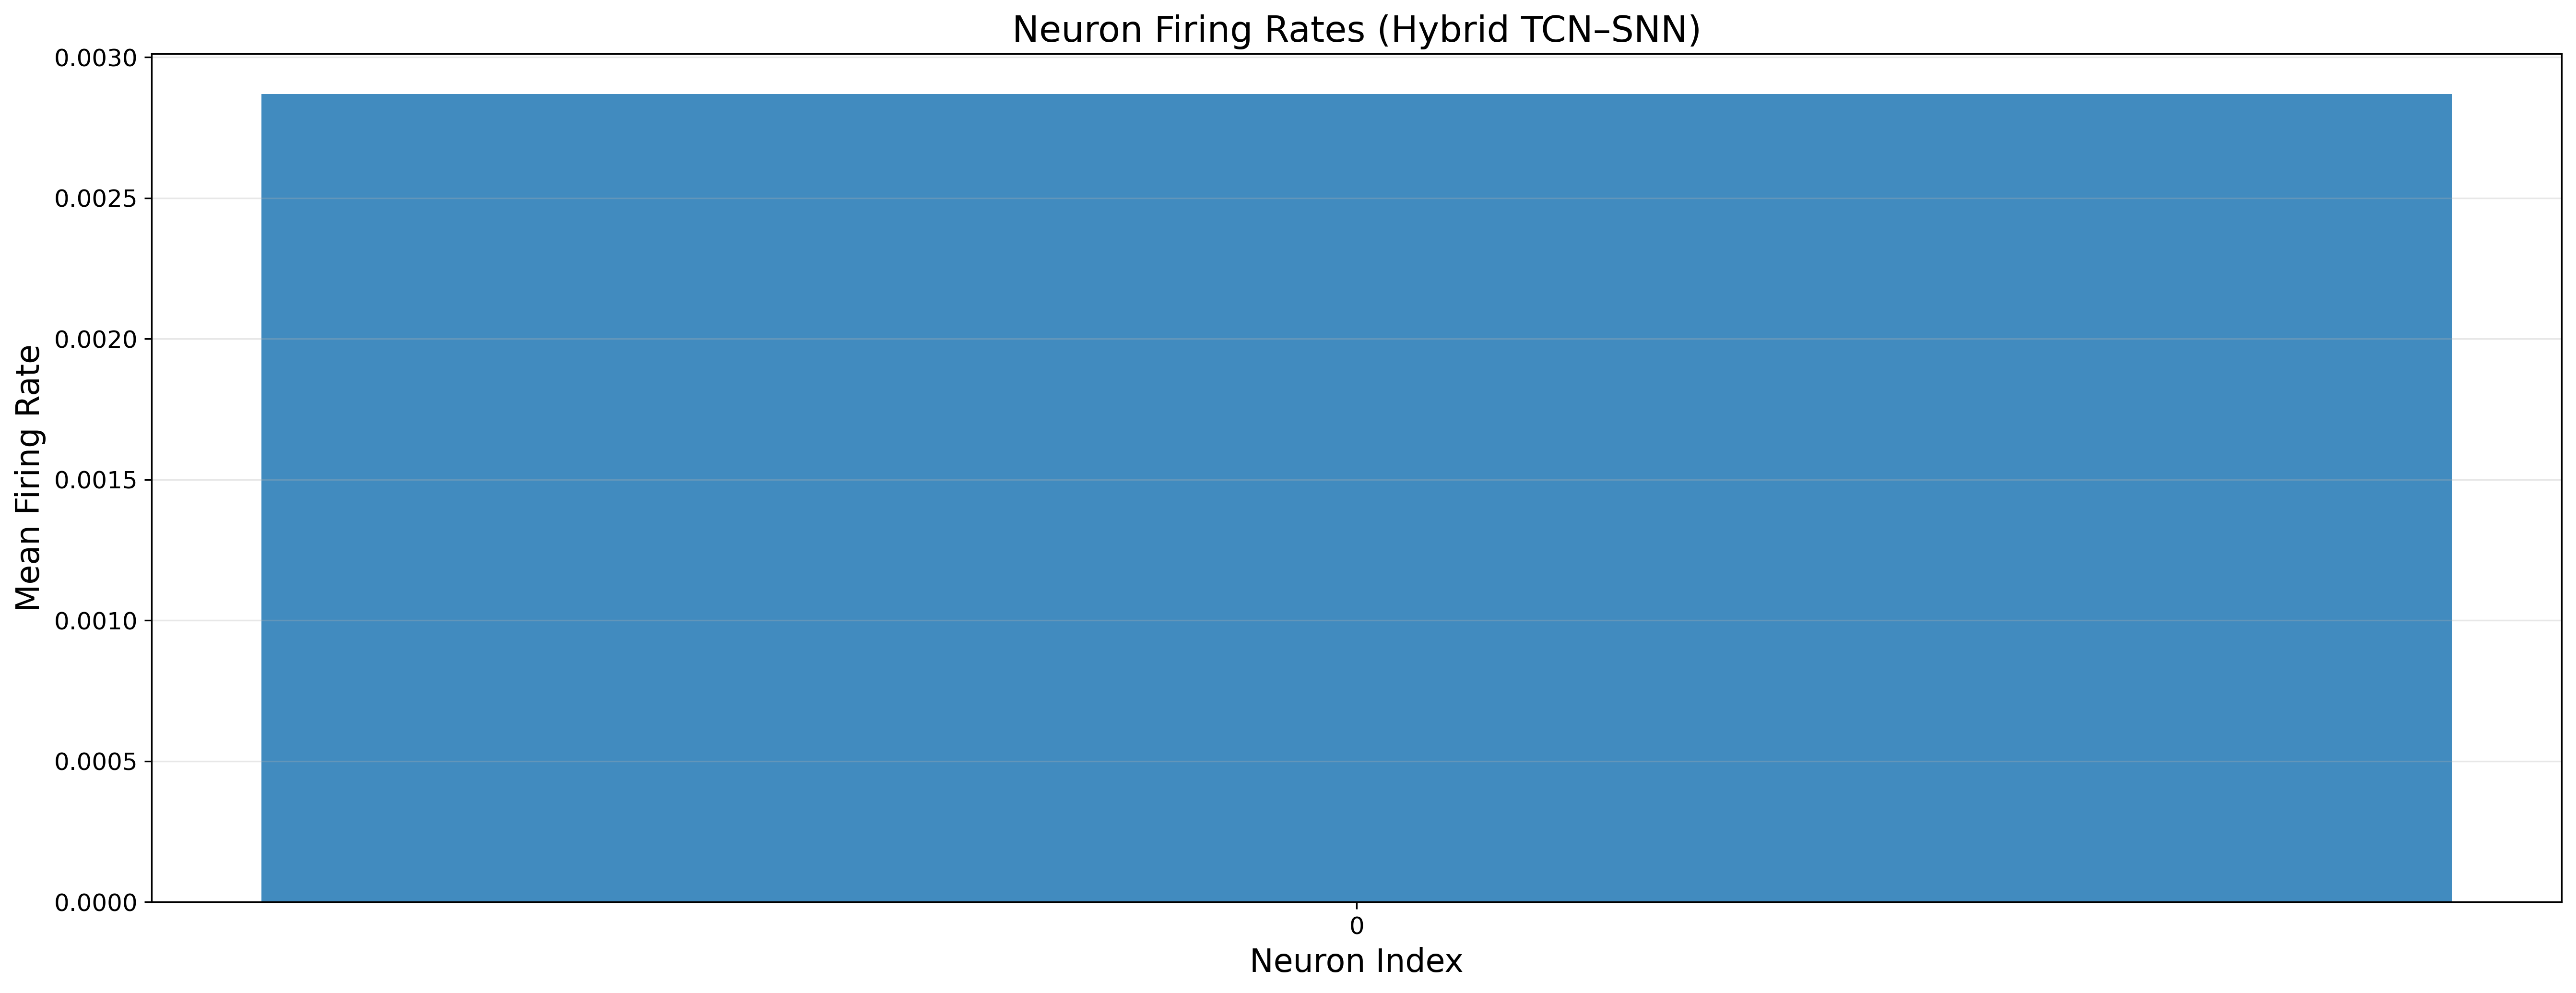

{'T': 100, 'N': 1, 'firing_rates': array([0.00286875], dtype=float32), 'spike_counts': array([0]), 'sparsity': 1.0, 'total_spikes': 0}


In [73]:
out = visualize_snn_spikes4(
    hybrid_model,
    sample_input,              # torch tensor
    num_steps=300,
    num_neurons=32,
    threshold=0.5,
    time_axis=0, neuron_axis=1, batch_axis=2,  # (100,200,32) 케이스
    batch_reduce="mean",       # 배치 평균 or "first"
    raster_size=(22, 11),
    hist_size=(18, 7),
    dpi=300,
    show_heatmap=True,
    save_prefix="runs/exp1/spikes",
    title_suffix="(Hybrid TCN–SNN)"
)
print(out)  # sparsity, total_spikes 등 요약 지표


In [91]:
def plot_snn_activity(model, sample_data, num_neurons=20, threshold=0.5,
                      take_first_batch=True, use_eventplot=True,
                      figsize=(14, 10), dpi=200):
    """
    SNNClassifier 전용 스파이크 활동 시각화:
      1) Raster plot
      2) 뉴런별 스파이크 개수 및 총합
      3) 뉴런별 평균 발화율 및 전체 평균

    Args:
        model: 학습된 SNNClassifier (model.snn 존재)
        sample_data: (B, T, F) 텐서 (배치가 있으면 첫 샘플 사용 권장)
        num_neurons: Raster plot에서 표시할 뉴런 수
        threshold: 스파이크 판정 임계값 (연속값일 때 이진화에 사용)
        take_first_batch: True면 입력의 첫 샘플만 사용
        use_eventplot: True면 eventplot(권장), False면 scatter('|')
        figsize: 전체 Figure 크기
        dpi: 해상도
    Returns:
        dict: {"total_spikes", "sparsity", "mean_firing_rate",
               "spike_counts"(N,), "firing_rates"(N,)}
    """
    import torch
    import numpy as np
    import matplotlib.pyplot as plt

    if not hasattr(model, "snn"):
        print("❌ 해당 모델에는 SNN 모듈(model.snn)이 없습니다.")
        return

    model.eval()
    device_local = next(model.parameters()).device
    with torch.no_grad():
        x = sample_data
        if take_first_batch and x.dim() >= 1:
            x = x[:1]
        x = x.to(device_local)

        out = model.snn(x)  # 보통 (num_steps, B, hidden) or (num_steps, hidden)
        # snntorch는 (spk, mem) 형태일 수도 있음 → 스파이크만 추출
        if isinstance(out, (tuple, list)):
            spk = out[0]
        else:
            spk = out
        spk = spk.detach().float().cpu()

    # --- 이진화: 연속값(막전위) 대비 ---
    # 값 분포가 0~1이고 유니크가 적으면 이미 스파이크일 가능성
    uniq = spk.unique().numel()
    if spk.min() >= 0 and spk.max() <= 1.0 and uniq <= 4:
        bin_spk = (spk > 0).to(torch.uint8)
    else:
        bin_spk = (spk > threshold).to(torch.uint8)

    # --- shape 정규화: 마지막 축을 뉴런(N)으로, 나머지 축은 시간으로 펼침 → (T*, N)
    arr = bin_spk.numpy()
    if arr.ndim < 2:
        raise ValueError(f"Unexpected spike shape: {arr.shape}")
    Tstar = int(np.prod(arr.shape[:-1]))
    N = arr.shape[-1]
    arr2d = arr.reshape(Tstar, N)   # (T*, N)

    # --- 표시 범위 제한 ---
    T_show = arr2d.shape[0]
    N_show = min(num_neurons, N)
    show2d = arr2d[:, :N_show]

    # --- 통계 ---
    spike_counts = show2d.sum(axis=0)               # (N_show,)
    firing_rates = show2d.mean(axis=0)              # (N_show,)
    total_spikes = int(show2d.sum())
    sparsity = 1.0 - (show2d.mean())                # 1에 가까울수록 스파스
    mean_firing_rate = float(firing_rates.mean())

    # --- 플롯 ---
    plt.figure(figsize=figsize, dpi=dpi)

    # 1) Raster
    ax1 = plt.subplot(3, 1, 1)
    if use_eventplot:
        times = [np.where(show2d[:, i] > 0)[0] for i in range(N_show)]
        ax1.eventplot(times, lineoffsets=np.arange(N_show),
                      linelengths=0.9, linewidths=1.2, colors='k')
    else:
        for i in range(N_show):
            t = np.where(show2d[:, i] > 0)[0]
            ax1.scatter(t, [i]*len(t), marker='|', s=120, alpha=0.85, color='k')
    ax1.set_title('SNN Spike Raster Plot', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Neuron Index')
    ax1.set_xlabel('Time Step')
    ax1.grid(True, axis='x', alpha=0.25)
    ax1.set_ylim(-0.5, N_show - 0.5)

    # 2) Spike Count per Neuron (+ Total)
    ax2 = plt.subplot(3, 1, 2)
    x_idx = np.arange(N_show)
    ax2.bar(x_idx, spike_counts, alpha=0.8)
    ax2.set_title(f'Spike Count per Neuron (Total: {total_spikes})',
                  fontsize=13, fontweight='bold')
    ax2.set_ylabel('Spike Count')
    ax2.grid(True, axis='y', alpha=0.3)

    # 3) Firing Rate per Neuron (+ Mean)
    ax3 = plt.subplot(3, 1, 3)
    ax3.bar(x_idx, firing_rates, alpha=0.8)
    ax3.set_title(f'Firing Rate per Neuron (Mean: {mean_firing_rate:.3f})',
                  fontsize=13, fontweight='bold')
    ax3.set_ylabel('Firing Rate')
    ax3.set_xlabel('Neuron Index')
    ax3.grid(True, axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

    return {
        "total_spikes": total_spikes,
        "sparsity": float(sparsity),
        "mean_firing_rate": mean_firing_rate,
        "spike_counts": spike_counts,
        "firing_rates": firing_rates,
    }


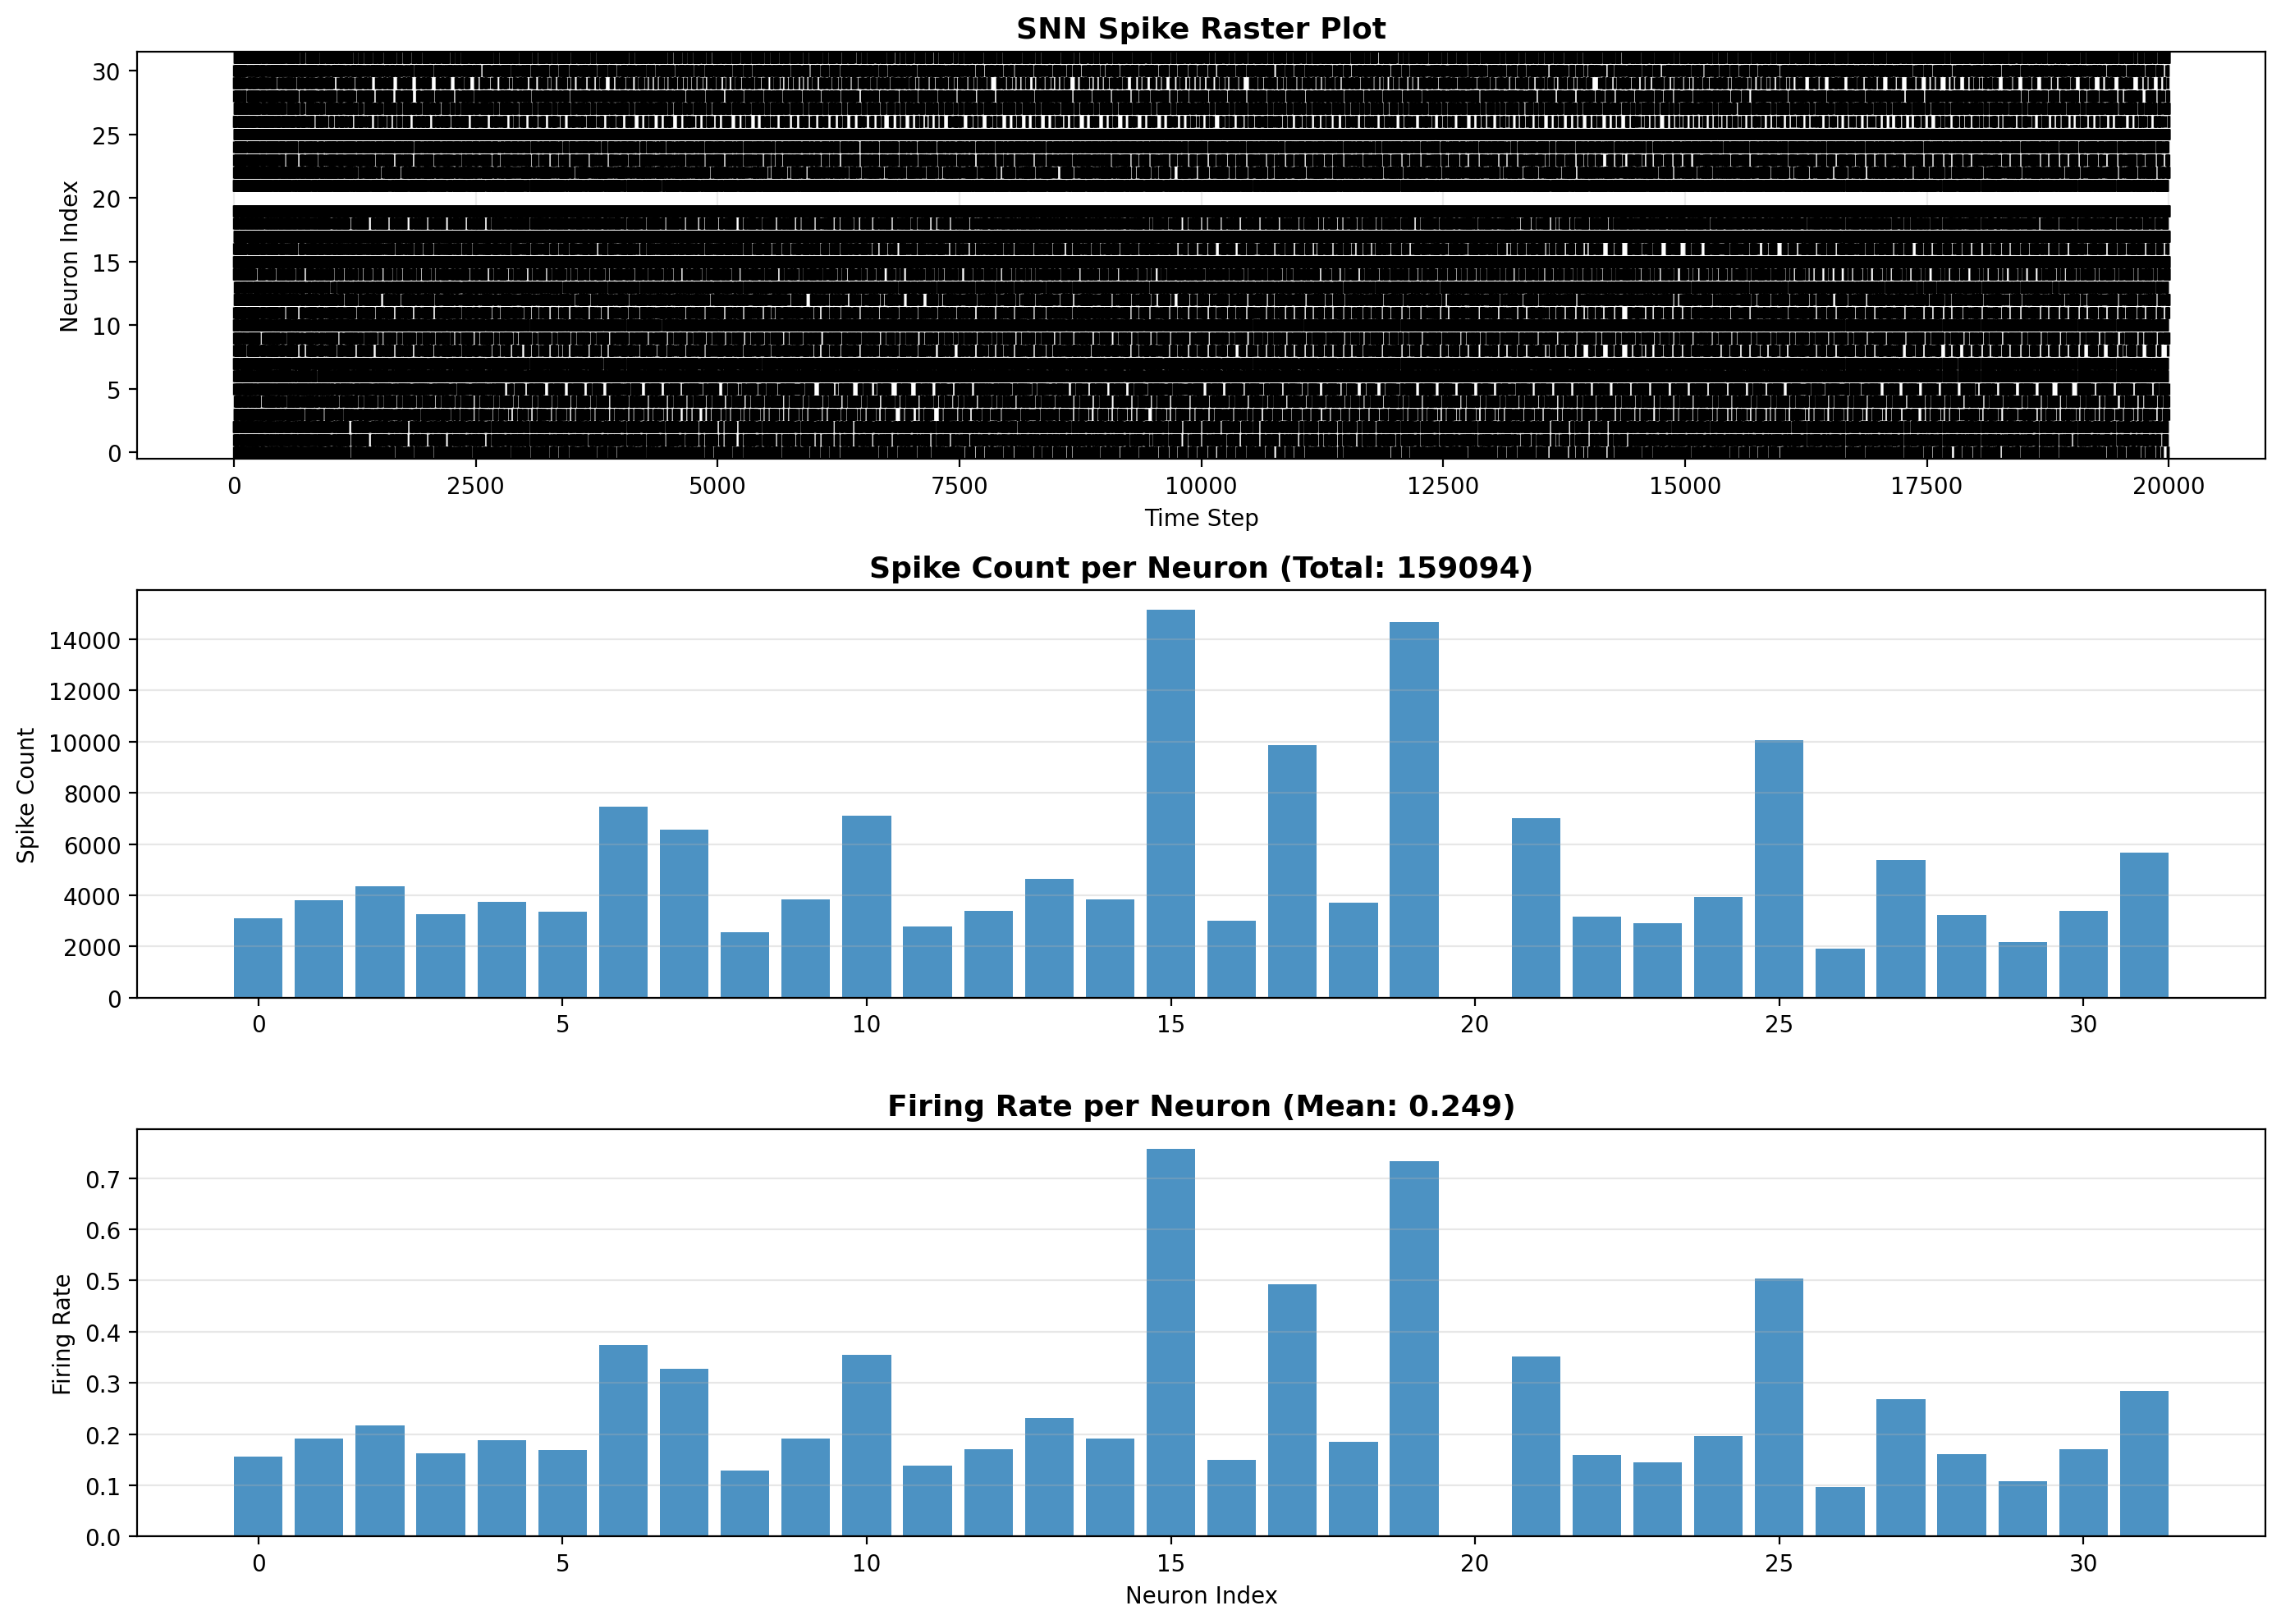

{'total_spikes': 159094, 'sparsity': 0.751415625, 'mean_firing_rate': 0.248584375, 'spike_counts': array([ 3114,  3816,  4345,  3266,  3751,  3369,  7475,  6552,  2566,
        3832,  7092,  2775,  3405,  4625,  3840, 15152,  3001,  9854,
        3708, 14672,     0,  7021,  3172,  2914,  3928, 10071,  1930,
        5374,  3217,  2177,  3403,  5677], dtype=uint64), 'firing_rates': array([0.1557 , 0.1908 , 0.21725, 0.1633 , 0.18755, 0.16845, 0.37375,
       0.3276 , 0.1283 , 0.1916 , 0.3546 , 0.13875, 0.17025, 0.23125,
       0.192  , 0.7576 , 0.15005, 0.4927 , 0.1854 , 0.7336 , 0.     ,
       0.35105, 0.1586 , 0.1457 , 0.1964 , 0.50355, 0.0965 , 0.2687 ,
       0.16085, 0.10885, 0.17015, 0.28385])}


In [92]:
# 테스트 배치에서 샘플 1개 가져오기
sample_X, _ = next(iter(test_loader))
metrics = plot_snn_activity(snn_model, sample_X, num_neurons=32, threshold=0.5)
print(metrics)


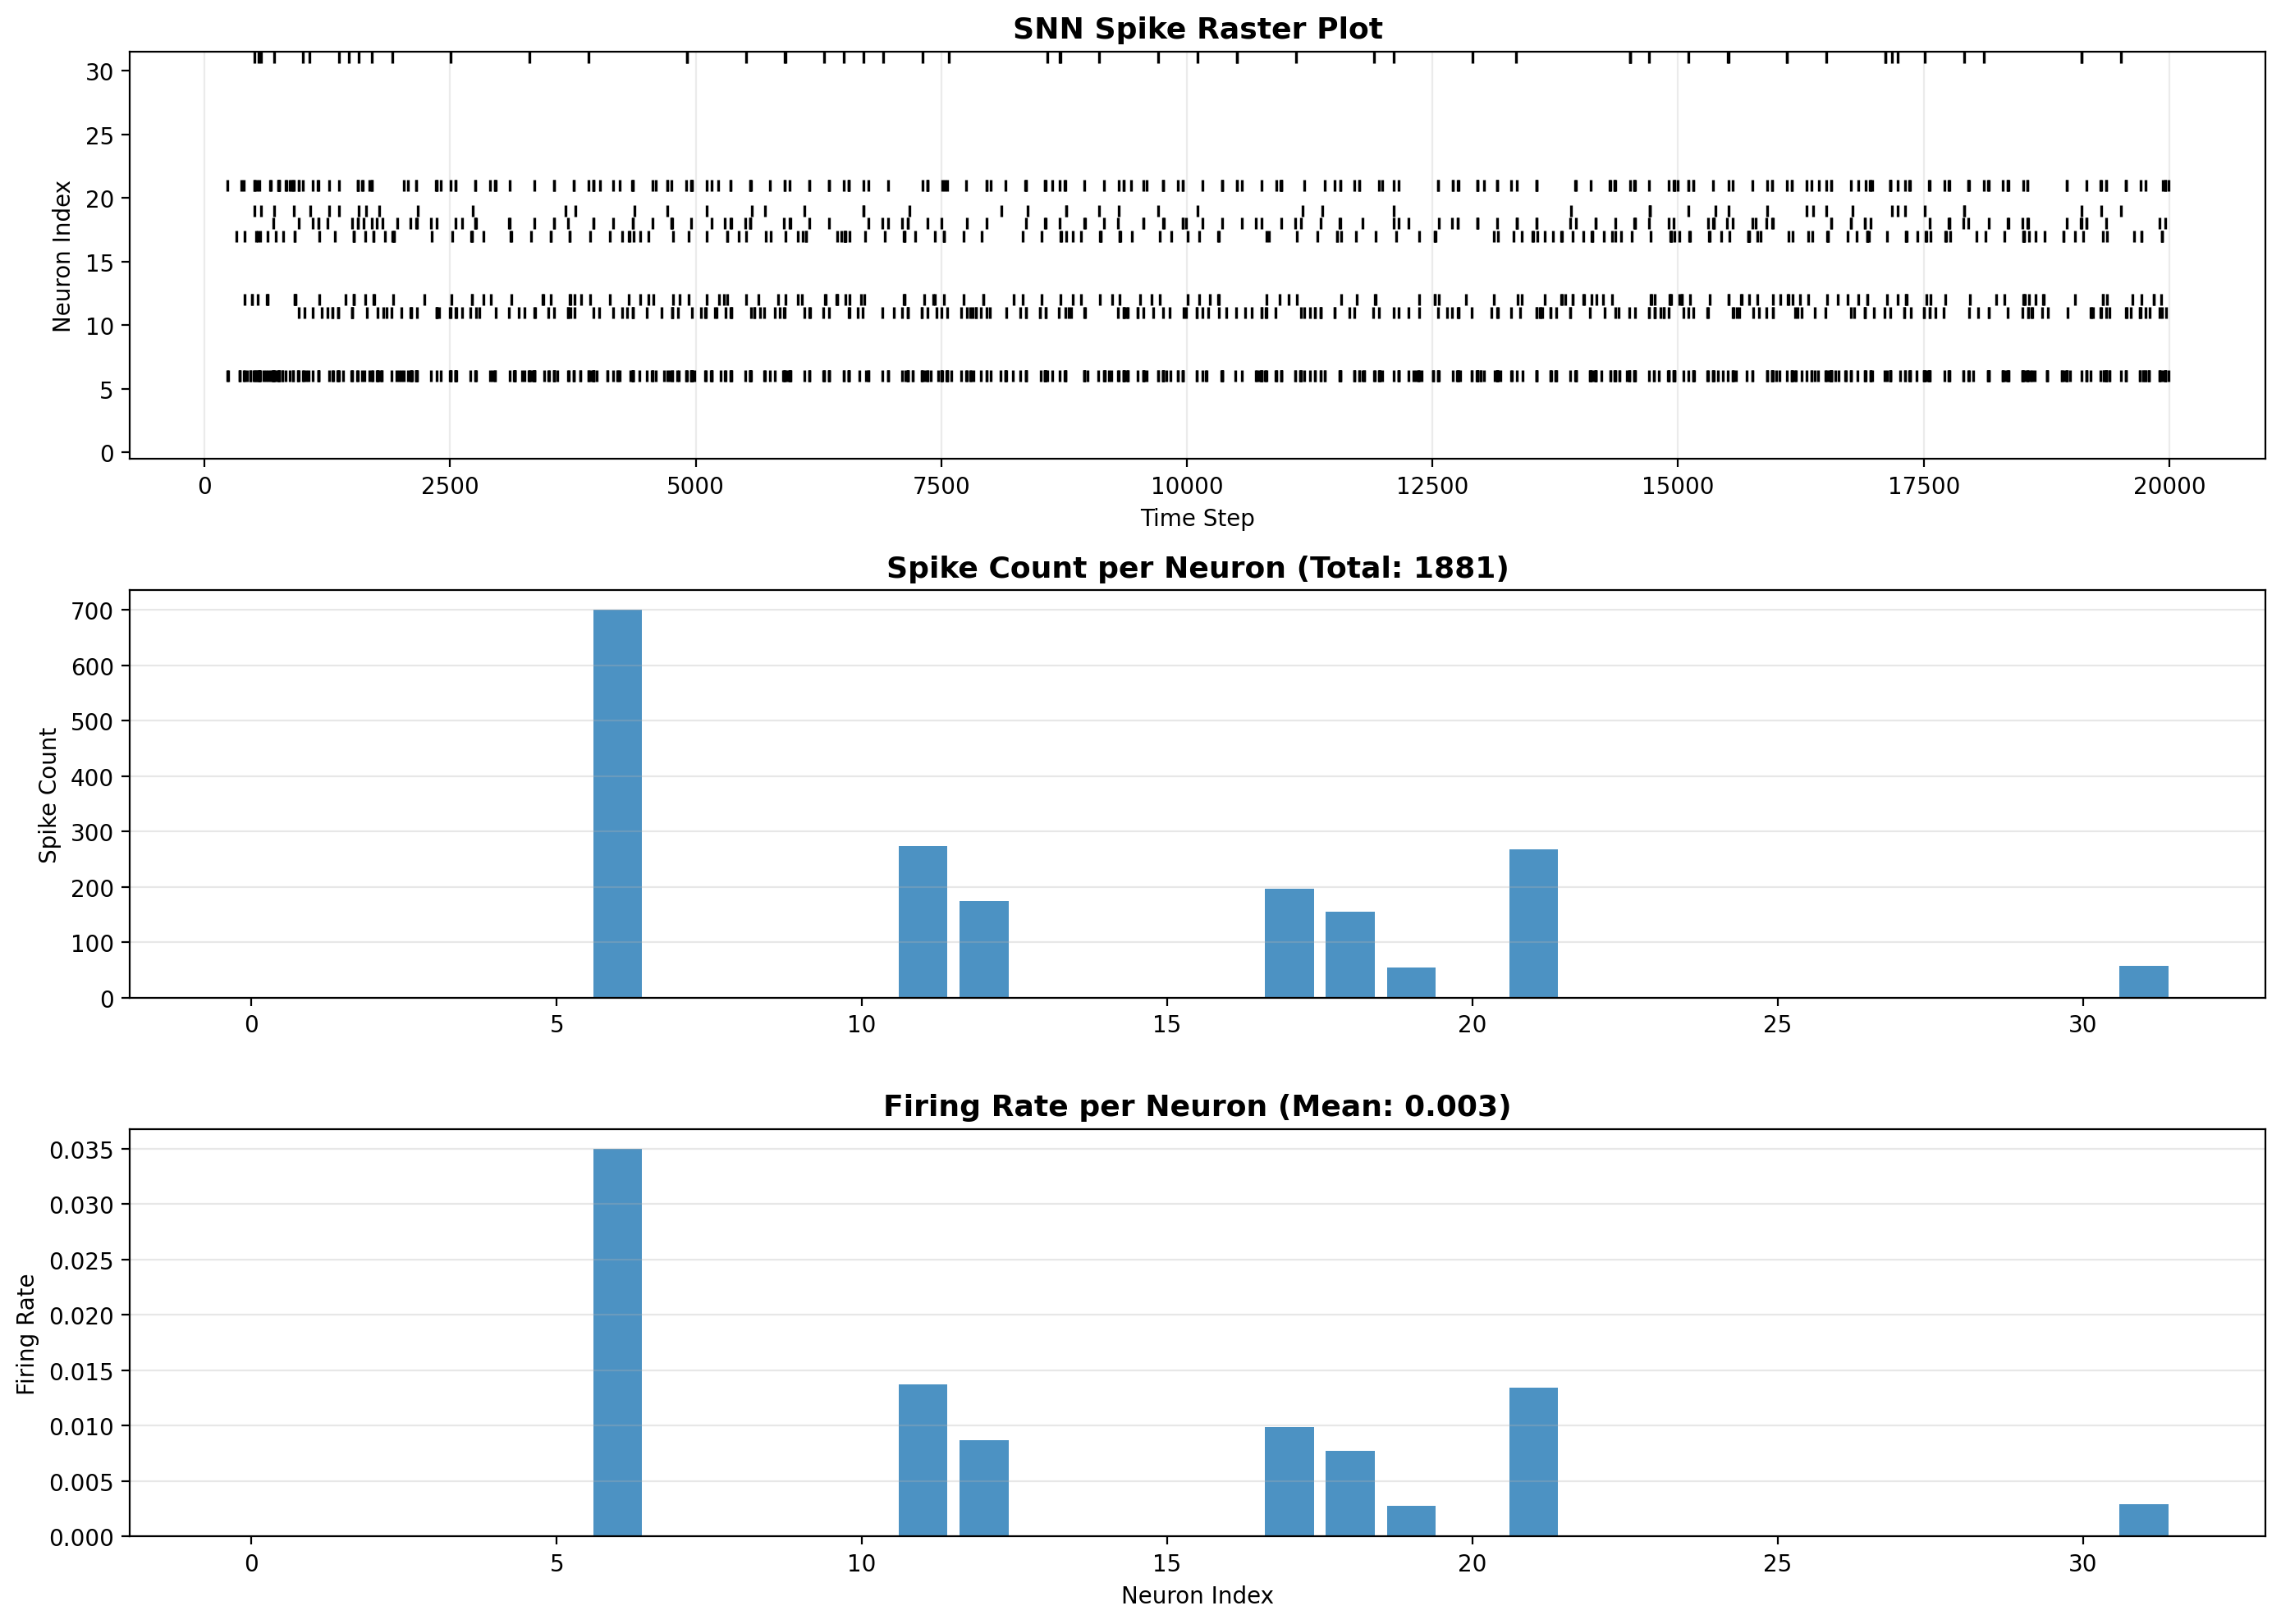

{'total_spikes': 1881, 'sparsity': 0.9970609375, 'mean_firing_rate': 0.0029390625, 'spike_counts': array([  0,   0,   0,   0,   0,   0, 700,   0,   0,   0,   0, 274, 174,
         0,   0,   0,   0, 197, 155,  55,   0, 268,   0,   0,   0,   0,
         0,   0,   0,   0,   0,  58], dtype=uint64), 'firing_rates': array([0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.035  ,
       0.     , 0.     , 0.     , 0.     , 0.0137 , 0.0087 , 0.     ,
       0.     , 0.     , 0.     , 0.00985, 0.00775, 0.00275, 0.     ,
       0.0134 , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
       0.     , 0.     , 0.     , 0.0029 ])}


In [93]:
# 테스트 배치에서 샘플 1개 가져오기
sample_X, _ = next(iter(test_loader))
metrics = plot_snn_activity(hybrid_model, sample_X, num_neurons=32, threshold=0.5)
print(metrics)


In [ ]:
def plot_snn_activity(model, sample_data, num_neurons=20, threshold=0.5,
                      take_first_batch=True, use_eventplot=True,
                      figsize=(14, 10), dpi=200):
    """
    SNNClassifier 전용 스파이크 활동 시각화:
      1) Raster plot
      2) 뉴런별 스파이크 개수 및 총합
      3) 뉴런별 평균 발화율 및 전체 평균

    Args:
        model: 학습된 SNNClassifier (model.snn 존재)
        sample_data: (B, T, F) 텐서 (배치가 있으면 첫 샘플 사용 권장)
        num_neurons: Raster plot에서 표시할 뉴런 수
        threshold: 스파이크 판정 임계값 (연속값일 때 이진화에 사용)
        take_first_batch: True면 입력의 첫 샘플만 사용
        use_eventplot: True면 eventplot(권장), False면 scatter('|')
        figsize: 전체 Figure 크기
        dpi: 해상도
    Returns:
        dict: {"total_spikes", "sparsity", "mean_firing_rate",
               "spike_counts"(N,), "firing_rates"(N,)}
    """
    import torch
    import numpy as np
    import matplotlib.pyplot as plt

    if not hasattr(model, "snn"):
        print("❌ 해당 모델에는 SNN 모듈(model.snn)이 없습니다.")
        return

    model.eval()
    device_local = next(model.parameters()).device
    with torch.no_grad():
        x = sample_data
        if take_first_batch and x.dim() >= 1:
            x = x[:1]
        x = x.to(device_local)

        out = model.snn(x)  # 보통 (num_steps, B, hidden) or (num_steps, hidden)
        # snntorch는 (spk, mem) 형태일 수도 있음 → 스파이크만 추출
        if isinstance(out, (tuple, list)):
            spk = out[0]
        else:
            spk = out
        spk = spk.detach().float().cpu()

    # --- 이진화: 연속값(막전위) 대비 ---
    # 값 분포가 0~1이고 유니크가 적으면 이미 스파이크일 가능성
    uniq = spk.unique().numel()
    if spk.min() >= 0 and spk.max() <= 1.0 and uniq <= 4:
        bin_spk = (spk > 0).to(torch.uint8)
    else:
        bin_spk = (spk > threshold).to(torch.uint8)

    # --- shape 정규화: 마지막 축을 뉴런(N)으로, 나머지 축은 시간으로 펼침 → (T*, N)
    arr = bin_spk.numpy()
    if arr.ndim < 2:
        raise ValueError(f"Unexpected spike shape: {arr.shape}")
    Tstar = int(np.prod(arr.shape[:-1]))
    N = arr.shape[-1]
    arr2d = arr.reshape(Tstar, N)   # (T*, N)

    # --- 표시 범위 제한 ---
    T_show = arr2d.shape[0]
    N_show = min(num_neurons, N)
    show2d = arr2d[:, :N_show]

    # --- 통계 ---
    spike_counts = show2d.sum(axis=0)               # (N_show,)
    firing_rates = show2d.mean(axis=0)              # (N_show,)
    total_spikes = int(show2d.sum())
    sparsity = 1.0 - (show2d.mean())                # 1에 가까울수록 스파스
    mean_firing_rate = float(firing_rates.mean())

    # --- 플롯 ---
    plt.figure(figsize=figsize, dpi=dpi)

    # 1) Raster
    ax1 = plt.subplot(3, 1, 1)
    if use_eventplot:
        times = [np.where(show2d[:, i] > 0)[0] for i in range(N_show)]
        ax1.eventplot(times, lineoffsets=np.arange(N_show),
                      linelengths=0.9, linewidths=1.2, colors='k')
    else:
        for i in range(N_show):
            t = np.where(show2d[:, i] > 0)[0]
            ax1.scatter(t, [i]*len(t), marker='|', s=120, alpha=0.85, color='k')
    ax1.set_title('SNN Spike Raster Plot', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Neuron Index')
    ax1.set_xlabel('Time Step')
    ax1.grid(True, axis='x', alpha=0.25)
    ax1.set_ylim(-0.5, N_show - 0.5)

    # 2) Spike Count per Neuron (+ Total)
    ax2 = plt.subplot(3, 1, 2)
    x_idx = np.arange(N_show)
    ax2.bar(x_idx, spike_counts, alpha=0.8)
    ax2.set_title(f'Spike Count per Neuron (Total: {total_spikes})',
                  fontsize=13, fontweight='bold')
    ax2.set_ylabel('Spike Count')
    ax2.grid(True, axis='y', alpha=0.3)

    # 3) Firing Rate per Neuron (+ Mean)
    ax3 = plt.subplot(3, 1, 3)
    ax3.bar(x_idx, firing_rates, alpha=0.8)
    ax3.set_title(f'Firing Rate per Neuron (Mean: {mean_firing_rate:.3f})',
                  fontsize=13, fontweight='bold')
    ax3.set_ylabel('Firing Rate')
    ax3.set_xlabel('Neuron Index')
    ax3.grid(True, axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

    return {
        "total_spikes": total_spikes,
        "sparsity": float(sparsity),
        "mean_firing_rate": mean_firing_rate,
        "spike_counts": spike_counts,
        "firing_rates": firing_rates,
    }
